# Singapore Job Market Analysis for Headhunting Firm
## Enhancing Placement Success through Data-Driven Insights

This notebook analyzes 100 job postings to identify patterns that improve candidate-company-role matching.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load the data
df = pd.read_csv(r'c:\Users\User\NTU_DSAI\Module-1\00_Coaching_Mod1_Project_1-2\data\SGJobData.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())

Dataset shape: (1048585, 22)

Column names:
['categories', 'employmentTypes', 'metadata_expiryDate', 'metadata_isPostedOnBehalf', 'metadata_jobPostId', 'metadata_newPostingDate', 'metadata_originalPostingDate', 'metadata_repostCount', 'metadata_totalNumberJobApplication', 'metadata_totalNumberOfView', 'minimumYearsExperience', 'numberOfVacancies', 'occupationId', 'positionLevels', 'postedCompany_name', 'salary_maximum', 'salary_minimum', 'salary_type', 'status_id', 'status_jobStatus', 'title', 'average_salary']


## 1. DATA OVERVIEW & QUALITY CHECK

In [2]:
# Data quality check
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal records: {len(df)}")
print(f"\nJob Status Distribution:")
print(df['status_jobStatus'].value_counts())
print(f"\nEmployment Types:")
print(df['employmentTypes'].value_counts())

Missing Values:
categories                         3988
employmentTypes                    3988
metadata_expiryDate                3988
metadata_jobPostId                 3988
metadata_newPostingDate            3988
metadata_originalPostingDate       3988
occupationId                    1048585
positionLevels                     3988
postedCompany_name                 3988
salary_type                        3988
status_jobStatus                   3988
title                              3988
dtype: int64

Total records: 1048585

Job Status Distribution:
Open       902614
Closed     119701
Re-open     22282
Name: status_jobStatus, dtype: int64

Employment Types:
Permanent                458139
Full Time                393352
Contract                 139182
Part Time                 25431
Temporary                 18241
Internship/Attachment      6959
Freelance                  2139
Flexi-work                 1154
Name: employmentTypes, dtype: int64


In [3]:
# Remove rows with missing values in critical columns
print("Data Cleaning - Remove rows with missing critical data:")
print("="*80)
print(f"Original dataset: {len(df)} rows")

# Define critical columns that must have values for analysis
critical_columns = ['categories', 'employmentTypes', 'title', 'salary_minimum', 
                   'salary_maximum', 'average_salary', 'postedCompany_name',
                   'positionLevels', 'metadata_totalNumberOfView']

# Remove rows with NaN/missing values in critical columns
initial_count = len(df)
df = df.dropna(subset=critical_columns)
rows_removed = initial_count - len(df)

print(f"After removing rows with missing critical data: {len(df)} rows")
print(f"Rows removed: {rows_removed}")

# Check if those 3988 rows are gone
print(f"\nMissing values summary AFTER cleaning:")
missing_after = df.isnull().sum()
print(missing_after[missing_after > 0])

print("="*80)

Data Cleaning - Remove rows with missing critical data:
Original dataset: 1048585 rows
After removing rows with missing critical data: 1044597 rows
Rows removed: 3988

Missing values summary AFTER cleaning:
occupationId    1044597
dtype: int64


In [ ]:
# Decided to do RUTHLESS filtering to remove outliers and junk data: minimumYearsExperience > 10 years, salary > $30,000/month, salary < $1,000/month, and constrain to 2023-May to 2024-May.

# RUTHLESS FILTERING - Create filtered dataframe for analysis
print("RUTHLESS DATA FILTERING - Creating df_filtered for analysis")
print("="*80)
print(f"Original records: {len(df)}")

# Create filtered dataframe for analysis
df_filtered = df.copy()

# 0. Constrain to date range: 2023-May to 2024-May
before = len(df_filtered)
df_filtered['posting_date'] = pd.to_datetime(df_filtered['metadata_newPostingDate'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['posting_date'])
df_filtered = df_filtered[(df_filtered['posting_date'] >= '2023-05-01') & (df_filtered['posting_date'] <= '2024-05-31')]
print(f"Constrained to 2023-May to 2024-May: {before - len(df_filtered)} rows dropped")

# 1. Remove jobs requiring more than 10 years experience
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['minimumYearsExperience'] <= 10]
print(f"Removed experience > 10 years: {before - len(df_filtered)} rows dropped")

# 2. Remove jobs with monthly salary > $30,000
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['salary_maximum'] <= 30000]
print(f"Removed salary > $30,000/month: {before - len(df_filtered)} rows dropped")

# 3. Remove jobs with monthly salary < $1,000
before = len(df_filtered)
df_filtered = df_filtered[df_filtered['salary_minimum'] >= 1000]
print(f"Removed salary < $1,000/month: {before - len(df_filtered)} rows dropped")

# Recalculate average_salary after filtering
df_filtered['average_salary'] = (df_filtered['salary_minimum'] + df_filtered['salary_maximum']) / 2

print(f"\nFiltered dataframe (df_filtered) records: {len(df_filtered)}")
print(f"Original dataframe (df) records: {len(df)}")
print(f"\nFiltered data ranges:")
print(f"  Date range: {df_filtered['posting_date'].min()} to {df_filtered['posting_date'].max()}")
print(f"  Experience: {df_filtered['minimumYearsExperience'].min()} - {df_filtered['minimumYearsExperience'].max()} years")
print(f"  Min Salary: ${df_filtered['salary_minimum'].min():,.0f} - ${df_filtered['salary_minimum'].max():,.0f}")
print(f"  Max Salary: ${df_filtered['salary_maximum'].min():,.0f} - ${df_filtered['salary_maximum'].max():,.0f}")
print(f"  Avg Salary: ${df_filtered['average_salary'].min():,.0f} - ${df_filtered['average_salary'].max():,.0f}")
print("="*80)

RUTHLESS DATA FILTERING - Creating df_filtered for analysis
Original records: 1044597
Removed experience > 10 years: 9199 rows dropped
Removed salary > $30,000/month: 1102 rows dropped
Removed salary < $1,000/month: 18428 rows dropped

Filtered dataframe (df_filtered) records: 1015868
Original dataframe (df) records: 1044597

Filtered data ranges:
  Experience: 0 - 10 years
  Min Salary: $1,000 - $30,000
  Max Salary: $1,000 - $30,000
  Avg Salary: $1,000 - $30,000


## 2. MARKET DEMAND INSIGHTS

In [5]:
import re
from collections import Counter
import pandas as pd

# Improved title cleaning (removes more noise)
def clean_title(title):
    if pd.isna(title):
        return ""
    title = str(title)
    # Lowercase
    title = title.lower()
    # Remove salary
    title = re.sub(r'\$?\s*\d{3,6}(?:-\d{3,6})?\s*(?:k|sgd|monthly|pm)?', ' ', title)
    # Remove locations/patterns
    title = re.sub(r'\b(singapore|west|east|north|central|clementi|tuas|jurong|chang i).*?\b', ' ', title, flags=re.I)
    # Remove fluff words
    title = re.sub(r'\b(up to|urgent|immediate|asap|attractive|entry level|no exp|fresh grad|bonus)\b', ' ', title)
    # Remove pipes and extra sections
    title = re.sub(r'\|.*', ' ', title)
    # Keep parens content but clean inside (optional: extract separately below)
    title = re.sub(r'\([^)]*\)', ' ', title)  # Remove parens entirely for main cleaning
    # Clean punctuation/spacing
    title = re.sub(r'[^a-z0-9\s]', ' ', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df_filtered['clean_title'] = df_filtered['title'].apply(clean_title)

# Generate bigrams & trigrams (core roles/skills)
def get_ngrams(text, n):
    if not text:
        return []
    words = text.split()
    return [' '.join(words[i:i+n]) for i in range(max(0, len(words)-n+1))]

# All bigrams/trigrams across dataset
all_bigrams = []
all_trigrams = []

for title in df_filtered['clean_title']:
    all_bigrams.extend(get_ngrams(title, 2))
    all_trigrams.extend(get_ngrams(title, 3))

top_bigrams = Counter(all_bigrams).most_common(100)
top_trigrams = Counter(all_trigrams).most_common(100)

# Convert to DataFrames for easy viewing/filtering
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Count'])
trigram_df = pd.DataFrame(top_trigrams, columns=['Trigram', 'Count'])

print("Top 50 Role/Skill Bigrams:")
display(bigram_df.head(50))

print("\nTop 50 Role/Skill Trigrams:")
display(trigram_df.head(50))

Top 50 Role/Skill Bigrams:


,Bigram,Count
0,customer service,16662
1,sales executive,16006
2,business development,14196
3,admin assistant,13682
4,project manager,13347
5,assistant manager,13161
6,sales manager,11163
7,marketing executive,10637
8,accounts executive,10630
9,project engineer,10574



Top 50 Role/Skill Trigrams:


,Trigram,Count
0,business development manager,5897
1,customer service officer,5262
2,1 year contract,4757
3,business development executive,4689
4,customer service executive,3853
5,6 months contract,2698
6,chef de partie,2657
7,senior software engineer,1966
8,patient service associate,1963
9,oil gas mnc,1934


# Cleaned Title-Based Role/Skill Insights

The raw n-gram extraction from job titles captured many genuine roles and skills, but also included noise like contract terms ("1 year contract") and work patterns ("5 days").  

I manually reviewed and filtered the top 50 bigrams and trigrams to keep only **true role/skill phrases** (e.g., job titles, functions, or implicit skills). Removed: contract lengths, work schedules, incentives, "MNC" mentions, and generic fluff.

These cleaned lists are far more actionable for headhunting — they highlight real demand niches.

## Top Genuine Role/Skill Bigrams (Filtered)

| Rank | Bigram                  | Original Count | Notes                          |
|------|-------------------------|----------------|--------------------------------|
| 1    | customer service        | 16662          | High-volume entry/mid level    |
| 2    | sales executive         | 16006          | Classic sales role             |
| 3    | business development    | 14196          | Often paired with manager/exec |
| 4    | admin assistant         | 13682          | Admin staple                   |
| 5    | project manager         | 13347          | Cross-industry                 |
| 6    | assistant manager       | 13161          | Common progression role        |
| 7    | sales manager           | 11163          | Leadership sales               |
| 8    | marketing executive     | 10637          | Digital/traditional mix        |
| 9    | accounts executive      | 10630          | Finance/admin overlap          |
| 10   | project engineer        | 10574          | Engineering/construction hot   |
| 11   | admin executive         | 10415          | Senior admin                   |
| 12   | software engineer       | 9433           | Tech core                      |
| 13   | quantity surveyor       | 8508           | Construction niche             |
| 14   | hr executive            | 7378           | Recruitment/HR ops             |
| 15   | sales engineer          | 6794           | Technical sales                |
| 16   | development manager     | 6788           | Biz dev leadership             |
| 17   | operations executive    | 6723           | Ops/support                    |
| 18   | senior executive        | 6186           | Mid-senior generic             |
| 19   | staff nurse             | 6116           | Healthcare demand              |
| 20   | human resource          | 6092           | HR functions                   |
| 21   | warehouse assistant     | 5781           | Logistics entry                |
| 22   | service officer         | 5731           | Customer-facing                |
| 23   | marketing manager       | 5653           | Marketing leadership           |
| 24   | accounts assistant      | 5509           | Junior finance                 |
| 25   | business analyst        | 5423           | Tech/business bridge           |
| 26   | development executive   | 5126           | Biz dev junior                 |
| 27   | service engineer        | 4985           | Field/tech support             |
| 28   | design engineer         | 4857           | Mechanical/electrical          |
| 29   | account executive       | 4848           | Sales/finance                  |
| 30   | service executive       | 4586           | Customer ops                   |
| 31   | account manager         | 4580           | Client management              |
| 32   | support engineer        | 4463           | IT/tech support                |
| 33   | sales coordinator       | 4345           | Sales admin                    |
| 34   | finance manager         | 4337           | Finance leadership             |
| 35   | operations manager      | 4213           | Ops leadership                 |
| 36   | management trainee      | 4203           | Grad/entry programs            |
| 37   | service crew            | 4146           | F&B/hospitality entry          |
| 38   | digital marketing       | 4086           | Growing digital                |
| 39   | electrical engineer     | 3955           | Engineering sub                |
| 40   | software developer      | 3938           | Tech core                      |
| 41   | restaurant manager      | 3935           | F&B leadership                 |
| 42   | senior manager          | 3893           | Senior leadership              |
| 43   | finance executive       | 3742           | Finance ops                    |

## Top Genuine Role/Skill Trigrams (Filtered)

| Rank | Trigram                        | Original Count | Notes                          |
|------|--------------------------------|----------------|--------------------------------|
| 1    | business development manager   | 5897           | Top sales leadership           |
| 2    | customer service officer       | 5262           | Service staple                 |
| 3    | business development executive | 4689           | Junior biz dev                 |
| 4    | customer service executive     | 3853           | Service mid                    |
| 5    | chef de partie                 | 2657           | F&B kitchen                    |
| 6    | senior software engineer       | 1966           | Senior tech                    |
| 7    | patient service associate      | 1963           | Healthcare front               |
| 8    | digital marketing executive    | 1707           | Digital growth                 |
| 9    | full stack developer           | 1685           | Hot tech skill                 |
| 10   | human resource executive       | 1589           | HR ops                         |
| 11   | resident technical officer     | 1386           | Construction oversight         |
| 12   | assistant restaurant manager   | 1324           | F&B progression                |
| 13   | senior accounts executive      | 1288           | Finance mid                    |
| 14   | senior hr executive            | 1262           | HR mid                         |
| 15   | hr admin executive             | 1257           | HR support                     |
| 16   | sales marketing executive      | 1191           | Sales/marketing blend          |
| 17   | desktop support engineer       | 1177           | IT support                     |
| 18   | senior quantity surveyor       | 1158           | Construction senior            |
| 19   | senior staff nurse             | 1133           | Healthcare senior              |
| 20   | sales and marketing            | 1125           | Blended function               |
| 21   | mechanical design engineer     | 1070           | Engineering niche              |
| 22   | field service engineer         | 1044           | Tech field work                |
| 23   | hr recruitment consultant      | 999            | Recruitment specialist         |
| 24   | senior project engineer        | 980            | Engineering leadership         |
| 25   | sales support executive        | 965            | Sales ops                      |
| 26   | marketing assistant manager    | 907            | Marketing progression          |
| 27   | it support engineer            | 905            | IT helpdesk                    |
| 28   | assistant project manager      | 899            | Project progression            |

## Quick Headhunting Takeaways
- **Volume Leaders**: Sales/Biz Dev, Admin/Customer Service, Project Management/Engineering.
- **Tech Standouts**: Software engineer/developer, full stack, senior software roles — likely higher salaries & harder to fill.
- **Niche Opportunities**: Construction (quantity surveyor, resident technical officer), Healthcare (nurses, patient service), F&B (chef/restaurant roles) — specialised = premium fees.

You can now group your dataset by these phrases (e.g., `df[df['clean_title'].str.contains('software engineer')]`) for salary/repost metrics.

## (1) Expand Categories: Create Separate Columns for Each Category in a Job

Many jobs have multiple categories (up to ~5 in this dataset). Instead of keeping them in a list or exploding the DataFrame (which would duplicate rows), we create a fixed number of new columns: `category_1`, `category_2`, ..., `category_5`.  
- The categories are sorted alphabetically per job to ensure consistency.  
- Empty strings for jobs with fewer categories.

```python



In [37]:
import pandas as pd
import json

# Robust parsing function (same as before)
def parse_categories(cats_str):
    if pd.isna(cats_str) or str(cats_str).strip() in ["", "nan"]:
        return []
    try:
        cats = json.loads(str(cats_str).replace("''", '"').replace('""', '"'))
        return sorted([item['category'] for item in cats if 'category' in item])
    except:
        return []

# Apply parsing
df_filtered['category_list'] = df_filtered['categories'].apply(parse_categories)

# Create up to 5 category columns (covers >99% of multi-category jobs)
max_cats = 5
for i in range(max_cats):
    col_name = f'category_{i+1}'
    df_filtered[col_name] = df_filtered['category_list'].apply(lambda x: x[i] if len(x) > i else '')

# Optional: Drop the temporary list column if no longer needed
# df_filtered = df_filtered.drop(columns=['category_list'])

print("Example of expanded categories:")
display(df_filtered[['categories', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5']].head(10))

print(f"\nMaximum number of categories in any job: {df_filtered['category_list'].apply(len).max()}")

Example of expanded categories:


,categories,category_1,category_2,category_3,category_4,category_5
0,"[{""id"":13,""category"":""Environment / Health""},{...",Environment / Health,Manufacturing,Sciences / Laboratory / R&D,,
1,"[{""id"":21,""category"":""Information Technology""}]",Information Technology,,,,
2,"[{""id"":33,""category"":""Repair and Maintenance""}]",Repair and Maintenance,,,,
3,"[{""id"":21,""category"":""Information Technology""}]",Information Technology,,,,
4,"[{""id"":2,""category"":""Admin / Secretarial""}]",Admin / Secretarial,,,,
5,"[{""id"":7,""category"":""Consulting""},{""id"":21,""ca...",Consulting,Information Technology,Professional Services,,
6,"[{""id"":21,""category"":""Information Technology""}]",Information Technology,,,,
7,"[{""id"":37,""category"":""Security and Investigati...",Security and Investigation,,,,
8,"[{""id"":1,""category"":""Accounting / Auditing / T...",Accounting / Auditing / Taxation,Logistics / Supply Chain,Sales / Retail,,
9,"[{""id"":7,""category"":""Consulting""},{""id"":14,""ca...",Consulting,Events / Promotions,Logistics / Supply Chain,Professional Services,Sales / Retail



Maximum number of categories in any job: 5


Top 15 Job Categories by Demand:
                            Category   Count
3             Information Technology  137805
13                       Engineering  133808
5                Admin / Secretarial  114350
23                  Customer Service  108652
19                            Others  103648
11                    Sales / Retail  102249
18         Building and Construction   82150
9   Accounting / Auditing / Taxation   77252
16                               F&B   71589
10          Logistics / Supply Chain   68188
27               Banking and Finance   60081
1                      Manufacturing   55873
32                   Human Resources   51568
36       Healthcare / Pharmaceutical   51405
22      Marketing / Public Relations   51186


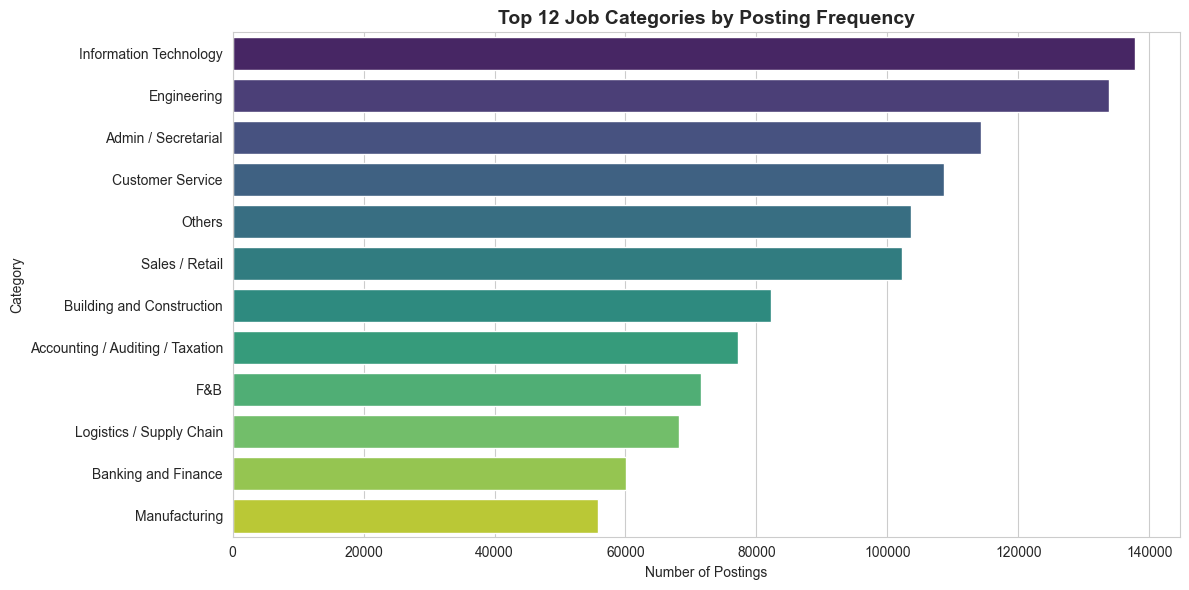

                                          categories employmentTypes  \
0  [{"id":13,"category":"Environment / Health"},{...       Permanent   
1    [{"id":21,"category":"Information Technology"}]       Permanent   
2    [{"id":33,"category":"Repair and Maintenance"}]       Full Time   
3    [{"id":21,"category":"Information Technology"}]       Permanent   
4        [{"id":2,"category":"Admin / Secretarial"}]       Full Time   

  metadata_expiryDate  metadata_isPostedOnBehalf metadata_jobPostId  \
0          2023-05-08                      False   MCF-2023-0252866   
1          2023-05-08                      False   MCF-2023-0273977   
2          2023-04-22                      False   MCF-2023-0273994   
3          2023-05-08                      False   MCF-2023-0273991   
4          2023-05-08                      False   MCF-2023-0273976   

  metadata_newPostingDate metadata_originalPostingDate  metadata_repostCount  \
0              2023-04-08                   2023-03-30      

In [38]:
# Flatten and count all categories
all_categories = []
for cats in df_filtered['category_list']:
    all_categories.extend(cats)

category_counts = Counter(all_categories)
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values('Count', ascending=False)

print("Top 15 Job Categories by Demand:")
print(category_df.head(15))

# Visualize top categories
plt.figure(figsize=(12, 6))
sns.barplot(data=category_df.head(12), x='Count', y='Category', palette='viridis')
plt.title('Top 12 Job Categories by Posting Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Number of Postings')
plt.tight_layout()
plt.show()

print(df_filtered.head())

In [40]:
from collections import Counter

# Create a clean combination key: sorted tuple of non-empty categories
def get_category_combo(row):
    cats = [row[f'category_{i+1}'] for i in range(5) if row[f'category_{i+1}'].strip() != '']
    return tuple(sorted(cats)) if cats else ('Uncategorized',)

df_filtered['category_combo'] = df_filtered.apply(get_category_combo, axis=1)

# Overall top combinations
combo_counts = df_filtered['category_combo'].value_counts()

print("Top 20 Category Combinations (including singles):")
display(combo_counts.head(20).to_frame('Job_Postings'))

# Separate single vs multi-category
single_category = combo_counts[combo_counts.index.map(len) == 1]
multi_category = combo_counts[combo_counts.index.map(len) > 1]

print("\nTop 10 Single-Category Postings:")
display(single_category.head(10).to_frame('Job_Postings'))

print("\nTop 20 Multi-Category Combinations (true hybrids):")
display(multi_category.head(20).to_frame('Job_Postings'))

# Quick stats
print(f"\nMulti-category jobs: {len(multi_category)} combinations, covering {multi_category.sum():,} postings "
      f"({multi_category.sum()/len(df_filtered)*100:.1f}% of total)")

Top 20 Category Combinations (including singles):


,Job_Postings
"(Information Technology,)",90747
"(Engineering,)",48463
"(F&B,)",47098
"(Accounting / Auditing / Taxation,)",44082
"(Building and Construction,)",43489
"(Admin / Secretarial,)",39137
"(Logistics / Supply Chain,)",30933
"(Sales / Retail,)",30393
"(Education and Training,)",28223
"(Banking and Finance,)",25845



Top 10 Single-Category Postings:


,Job_Postings
"(Information Technology,)",90747
"(Engineering,)",48463
"(F&B,)",47098
"(Accounting / Auditing / Taxation,)",44082
"(Building and Construction,)",43489
"(Admin / Secretarial,)",39137
"(Logistics / Supply Chain,)",30933
"(Sales / Retail,)",30393
"(Education and Training,)",28223
"(Banking and Finance,)",25845



Top 20 Multi-Category Combinations (true hybrids):


,Job_Postings
"(Building and Construction, Engineering)",8887
"(Engineering, Manufacturing)",8297
"(Engineering, Information Technology)",6519
"(Logistics / Supply Chain, Others)",5560
"(Admin / Secretarial, Human Resources)",5322
"(Accounting / Auditing / Taxation, Banking and Finance)",5131
"(Banking and Finance, Information Technology)",4935
"(Admin / Secretarial, Customer Service)",4690
"(Accounting / Auditing / Taxation, Admin / Secretarial)",4173
"(Others, Sales / Retail)",3953



Multi-category jobs: 20570 combinations, covering 378,945 postings (37.3% of total)


In [ ]:
# Priority role phrases (trigrams first, then bigrams) — from our filtered list
priority_roles = [
    # High-precision trigrams
    'business development manager', 'customer service officer', 'business development executive',
    'customer service executive', 'chef de partie', 'senior software engineer', 'patient service associate',
    'digital marketing executive', 'full stack developer', 'human resource executive',
    'resident technical officer', 'assistant restaurant manager', 'senior accounts executive',
    'senior hr executive', 'hr admin executive', 'desktop support engineer', 'senior quantity surveyor',
    'senior staff nurse', 'mechanical design engineer', 'field service engineer',
    'hr recruitment consultant', 'senior project engineer', 'sales support executive',
    'it support engineer', 'assistant project manager',
    # Key bigrams
    'software engineer', 'project manager', 'sales executive', 'admin executive', 'accounts executive',
    'project engineer', 'quantity surveyor', 'sales manager', 'marketing executive', 'hr executive',
    'business analyst', 'staff nurse', 'service engineer', 'design engineer', 'account manager'
]

def extract_key_role(clean_title):
    if not clean_title:
        return 'unknown'
    clean_title = ' ' + clean_title + ' '  # padding for easier contains
    for role in priority_roles:
        if ' ' + role + ' ' in clean_title:
            return role
    # Fallback: first 2-3 words (often the core role)
    words = clean_title.split()
    return ' '.join(words[:3]) if len(words) >= 3 else ' '.join(words)

df_filtered['key_role'] = df_filtered['clean_title'].apply(extract_key_role)

# Show results
print("Example of key role extraction:")
display(df_filtered[['title', 'clean_title', 'key_role']].head(15))

print("\nTop 30 extracted key roles:")
display(df_filtered['key_role'].value_counts().head(30))

Example of key role extraction:


,title,clean_title,key_role
0,Food Technologist - Clementi | Entry Level | U...,food technologist,food technologist
1,"Software Engineer (Fab Support) (Java, CIM, Up...",software engineer ds,software engineer
2,Senior Technician,senior technician,senior technician
3,"Senior .NET Developer (.NET Core, MVC, MVVC, S...",senior net developer ds,senior net developer
4,Sales / Admin Cordinator,sales admin cordinator,sales admin cordinator
5,Software Support Engineer,software support engineer,software support engineer
6,Urgent Hiring!!! Business Development Manager ...,hiring business development manager,business development manager
7,IT Security Engineer (Maritime/ Cloud Security),it security engineer,it security engineer
8,Assistant Sales Manager (Hunter Role)- Up to $...,assistant sales manager 5,sales manager
9,"Car Leasing, RM – West|Entry Level | Up to Bas...",car leasing rm,car leasing rm



Top 30 extracted key roles:


sales executive                   15893
supervisor                        13234
project manager                   12218
sales manager                     10855
project engineer                   9360
accounts executive                 9246
admin executive                    9141
marketing executive                8837
software engineer                  7331
quantity surveyor                  7173
hr executive                       6043
business development manager       5871
customer service officer           5261
business analyst                   5249
admin assistant                    5148
chef                               4932
staff nurse                        4819
business development executive     4682
account manager                    4491
service engineer                   3914
customer service executive         3842
design engineer                    3748
driver                             3723
warehouse assistant                3399
accounts assistant                 3117


In [ ]:
# Explode to assign each category in a job equally (standard approach for multi-category analysis)
df_exploded = df_filtered.explode('category_list')
df_exploded = df_exploded[df_exploded['category_list'].notna() & (df_exploded['category_list'].str.strip() != '')]

# Top categories for reference
top_categories = df_exploded['category_list'].value_counts().head(15).index

print("=== Top Key Roles per Major Category ===\n")
for cat in top_categories:
    subset = df_exploded[df_exploded['category_list'] == cat]
    print(f"{cat} ({len(subset)} postings, Avg Salary ${subset['average_salary'].mean():,.0f})")
    display(subset['key_role'].value_counts().head(10).to_frame('Count'))
    print("\n")

# Multi-category niche analysis
multi_jobs = df_filtered[df_filtered['category_combo'].map(len) > 1].copy()
print(f"\nMulti-Category Jobs Analysis ({len(multi_jobs)} postings)\n")

top_multi_combos = multi_category.head(10).index
for combo in top_multi_combos:
    subset = df_filtered[df_filtered['category_combo'] == combo]
    print(f"Combo: {', '.join(combo)} ({len(subset)} postings, "
          f"Avg Salary ${subset['average_salary'].mean():,.0f})")
    display(subset['key_role'].value_counts().head(8).to_frame('Count'))
    print("\n")

=== Top Key Roles per Major Category ===

Information Technology (137805 postings, Avg Salary $6,822)


,Count
software engineer,6011
project manager,4375
business analyst,3869
software developer,2056
senior software engineer,1743
full stack developer,1551
network engineer,1380
project engineer,1257
desktop support engineer,1143
system engineer,1138




Engineering (133808 postings, Avg Salary $4,893)


,Count
project engineer,6560
service engineer,3141
project manager,2949
design engineer,2676
software engineer,2550
quantity surveyor,1732
sales engineer,1446
electrical engineer,1285
sales manager,1282
sales executive,1178




Admin / Secretarial (114350 postings, Avg Salary $3,187)


,Count
admin executive,7753
admin assistant,4855
administrative assistant,1882
hr executive,1617
customer service officer,1256
sales coordinator,1245
supervisor,965
temp admin assistant,955
business development manager,949
accounts executive,913




Customer Service (108652 postings, Avg Salary $3,511)


,Count
customer service officer,4685
customer service executive,3238
sales executive,2954
admin executive,1761
sales manager,1243
admin assistant,1131
patient service associate,1017
hr recruitment consultant,971
business development executive,732
marketing executive,718




Others (103648 postings, Avg Salary $4,178)


,Count
supervisor,2912
sales executive,1579
project engineer,1435
warehouse assistant,1248
sales manager,1204
admin executive,1001
service engineer,875
admin assistant,829
software engineer,805
business development executive,767




Sales / Retail (102249 postings, Avg Salary $4,294)


,Count
sales executive,13239
sales manager,7831
business development executive,2550
account manager,2345
business development manager,2223
sales engineer,2117
marketing executive,2107
sales supervisor,1140
sales coordinator,1095
customer service officer,779




Building and Construction (82150 postings, Avg Salary $4,570)


,Count
quantity surveyor,6195
project manager,4124
project engineer,4103
site supervisor,1802
site engineer,1645
resident technical officer,1180
senior quantity surveyor,1067
project coordinator,1037
driver,904
bim modeller,723




Accounting / Auditing / Taxation (77252 postings, Avg Salary $4,311)


,Count
accounts executive,8738
accountant,2927
accounts assistant,2924
admin executive,2081
account executive,1696
finance manager,1562
finance executive,1396
senior accounts executive,1262
hr executive,942
account assistant,900




F&B (71589 postings, Avg Salary $3,733)


,Count
chef,4371
supervisor,2905
chef de partie,2464
service crew,1941
cook,1933
restaurant manager,1724
management trainee,1432
assistant cook,1386
assistant restaurant manager,1267
head chef,1086




Logistics / Supply Chain (68188 postings, Avg Salary $3,857)


,Count
warehouse assistant,2532
operations executive,981
class 4 driver,951
sales executive,898
prime mover driver,873
delivery driver,868
customer service executive,868
driver,800
sales manager,767
logistics executive,669




Banking and Finance (60081 postings, Avg Salary $6,709)


,Count
business analyst,1420
accounts executive,1065
project manager,722
finance manager,677
admin executive,675
business development manager,596
relationship manager,467
finance executive,462
secretary executive assistant,426
office administrator mnc,425




Manufacturing (55873 postings, Avg Salary $4,222)


,Count
project engineer,1226
supervisor,1121
sales executive,810
software engineer,782
production operator,583
driver,558
sales manager,539
service engineer,520
senior software engineer,502
warehouse assistant,479




Human Resources (51568 postings, Avg Salary $4,028)


,Count
hr executive,5598
admin executive,1753
human resource executive,1487
senior hr executive,1242
hr admin executive,1159
hr recruitment consultant,996
recruitment consultant,915
hr manager,818
admin assistant,742
hr assistant,613




Healthcare / Pharmaceutical (51405 postings, Avg Salary $4,162)


,Count
staff nurse,4517
patient service associate,1571
clinic assistant,1269
senior staff nurse,1095
enrolled nurse,771
spa therapist,414
healthcare assistant,385
dental assistant,363
sales executive,329
medical sales representative,316




Marketing / Public Relations (51186 postings, Avg Salary $4,749)


,Count
marketing executive,7563
sales executive,1811
marketing manager,1795
digital marketing executive,1565
business development executive,1047
business development manager,931
sales manager,880
admin assistant,642
marketing assistant manager,632
full time tuition,607





Multi-Category Jobs Analysis (378945 postings)

Combo: Building and Construction, Engineering (8887 postings, Avg Salary $4,888)


,Count
project engineer,1122
quantity surveyor,608
project manager,535
resident technical officer,338
site engineer,252
senior project engineer,182
electrical engineer,177
resident engineer,170




Combo: Engineering, Manufacturing (8297 postings, Avg Salary $4,236)


,Count
quality engineer,289
service engineer,270
process engineer mnc,177
design engineer,153
manufacturing engineer,150
project engineer,144
production supervisor medical,131
process engineer,113




Combo: Engineering, Information Technology (6519 postings, Avg Salary $5,460)


,Count
euc engineer,573
software engineer,573
service desk engineer,311
desktop support engineer,254
network engineer,218
system engineer,154
senior software engineer,113
project manager,111




Combo: Logistics / Supply Chain, Others (5560 postings, Avg Salary $3,213)


,Count
warehouse assistant,666
prime mover driver,378
class 4 driver,296
class 3 driver,242
operations executive,221
operations assistant,115
class 4 lorry,99
lorry crane driver,89




Combo: Admin / Secretarial, Human Resources (5322 postings, Avg Salary $3,139)


,Count
hr executive,514
hr recruitment trainee,469
business development executive,421
hr admin executive,419
admin executive,257
hr admin assistant,197
human resource executive,158
hr and admin,154




Combo: Accounting / Auditing / Taxation, Banking and Finance (5131 postings, Avg Salary $5,898)


,Count
accounts executive,316
finance manager,305
finance executive,223
accountant,93
corporate development analyst,87
assistant finance manager,80
accounts assistant,75
senior finance manager,74




Combo: Banking and Finance, Information Technology (4935 postings, Avg Salary $8,926)


,Count
business analyst,575
project manager,229
software engineer,208
software developer,93
junior quant researcher,69
full stack developer,53
system analyst,44
senior software engineer,37




Combo: Admin / Secretarial, Customer Service (4690 postings, Avg Salary $2,615)


,Count
customer service officer,276
admin executive,244
customer service executive,220
admin assistant,190
admin,183
administrative assistant,86
sales coordinator,83
receptionist,76




Combo: Accounting / Auditing / Taxation, Admin / Secretarial (4173 postings, Avg Salary $2,942)


,Count
accounts executive,412
admin executive,321
accounts assistant,264
admin assistant,176
accounts cum admin,126
temp accounts assistant,109
accounts admin assistant,96
admin accounts assistant,89




Combo: Others, Sales / Retail (3953 postings, Avg Salary $3,872)


,Count
sales executive,797
sales manager,598
sales engineer,451
account manager,190
sales coordinator,111
sales support,76
retail sales assistant,73
business development executive,71


## 3. EXPERIENCE LEVEL REQUIREMENTS

In [11]:
# Distribution by position level
print("Position Levels (Seniority):")
level_counts = df['positionLevels'].value_counts()
print(level_counts)

# Experience requirements
print(f"\nExperience Statistics (in years):")
print(df['minimumYearsExperience'].describe())

# Correlation between experience and salary
avg_salary_by_exp = df_filtered.groupby('minimumYearsExperience').agg({
    'average_salary': ['mean', 'count'],
    'salary_minimum': 'mean',
    'salary_maximum': 'mean'
}).round(0)

print(f"\nAverage Salary by Experience Level:")
print(avg_salary_by_exp)

Position Levels (Seniority):
Executive            253701
Junior Executive     167656
Non-executive        131608
Fresh/entry level    118661
Professional         112208
Manager              110122
Senior Executive     100459
Middle Management     27375
Senior Management     22807
Name: positionLevels, dtype: int64

Experience Statistics (in years):
count    1.044597e+06
mean     2.790185e+00
std      2.536057e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      8.800000e+01
Name: minimumYearsExperience, dtype: float64

Average Salary by Experience Level:
                       average_salary         salary_minimum salary_maximum
                                 mean   count           mean           mean
minimumYearsExperience                                                     
0                              3151.0  105211         2559.0         3743.0
1                              3284.0  258065         2698.0         3869.0
2          

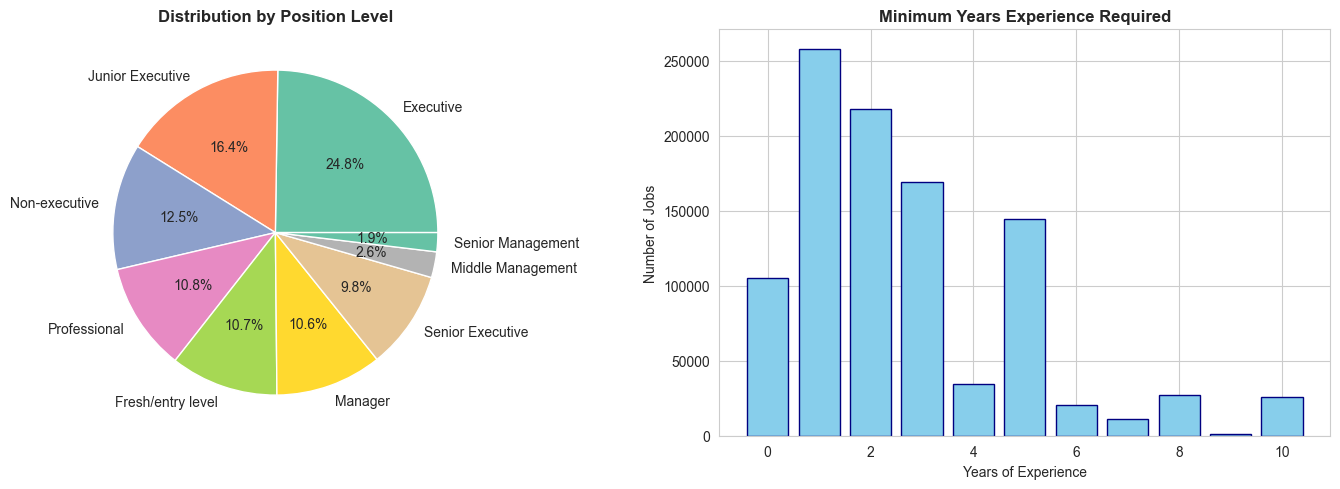

In [12]:
# Visualize position levels and experience
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Position levels pie chart
level_counts = df_filtered['positionLevels'].value_counts()
level_counts.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
axes[0].set_title('Distribution by Position Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('')

# Experience distribution
exp_dist = df_filtered['minimumYearsExperience'].value_counts().sort_index()
axes[1].bar(exp_dist.index, exp_dist.values, color='skyblue', edgecolor='navy')
axes[1].set_title('Minimum Years Experience Required', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Number of Jobs')

plt.tight_layout()
plt.show()

Normal distribution curve (almost) with the peak at one year of experience.
Executive and Senior Executive levels together have 34.6% vacancies. Professional occupies only 10.8%. 
Fresh / entry level also occupies 10.7%, together with Non-executive, add up to 23.2%. This suggests a top-heavy labour market.

## 4. COMPENSATION INTELLIGENCE

In [13]:
# Overall salary statistics
print("SALARY STATISTICS (Monthly, SGD):")
print(f"\nMinimum Salary:")
print(df_filtered['salary_minimum'].describe())
print(f"\nMaximum Salary:")
print(df_filtered['salary_maximum'].describe())
print(f"\nAverage Salary (Mid-point):")
print(df_filtered['average_salary'].describe())

# Top paying roles
print(f"\n\nTop 10 Highest Paying Positions:")
top_paying = df_filtered.nlargest(10, 'average_salary')[['title', 'average_salary', 'positionLevels', 'minimumYearsExperience']]
print(top_paying.to_string())

SALARY STATISTICS (Monthly, SGD):

Minimum Salary:
count    1.015868e+06
mean     3.789821e+03
std      2.175602e+03
min      1.000000e+03
25%      2.500000e+03
50%      3.000000e+03
75%      4.500000e+03
max      3.000000e+04
Name: salary_minimum, dtype: float64

Maximum Salary:
count    1.015868e+06
mean     5.511885e+03
std      3.429136e+03
min      1.000000e+03
25%      3.450000e+03
50%      4.500000e+03
75%      6.500000e+03
max      3.000000e+04
Name: salary_maximum, dtype: float64

Average Salary (Mid-point):
count    1.015868e+06
mean     4.650853e+03
std      2.752839e+03
min      1.000000e+03
25%      3.000000e+03
50%      3.850000e+03
75%      5.500000e+03
max      3.000000e+04
Name: average_salary, dtype: float64


Top 10 Highest Paying Positions:
                                                    title  average_salary     positionLevels  minimumYearsExperience
919051                             VP Delivery Head JAPAC         30000.0  Senior Management                    

Salary by Position Level:
                  average_salary                        
                            mean  median     std   count
positionLevels                                          
Senior Management         9872.0  8888.0  4364.0   19254
Middle Management         7348.0  6500.0  4013.0   26071
Professional              6904.0  6000.0  3544.0  109312
Manager                   6673.0  6000.0  2831.0  107694
Senior Executive          5620.0  5000.0  2303.0   99377
Executive                 4137.0  3750.0  1618.0  251532
Junior Executive          3411.0  3150.0  1356.0  166201
Non-executive             3037.0  2750.0  1346.0  127387
Fresh/entry level         2905.0  2650.0  1227.0  109040


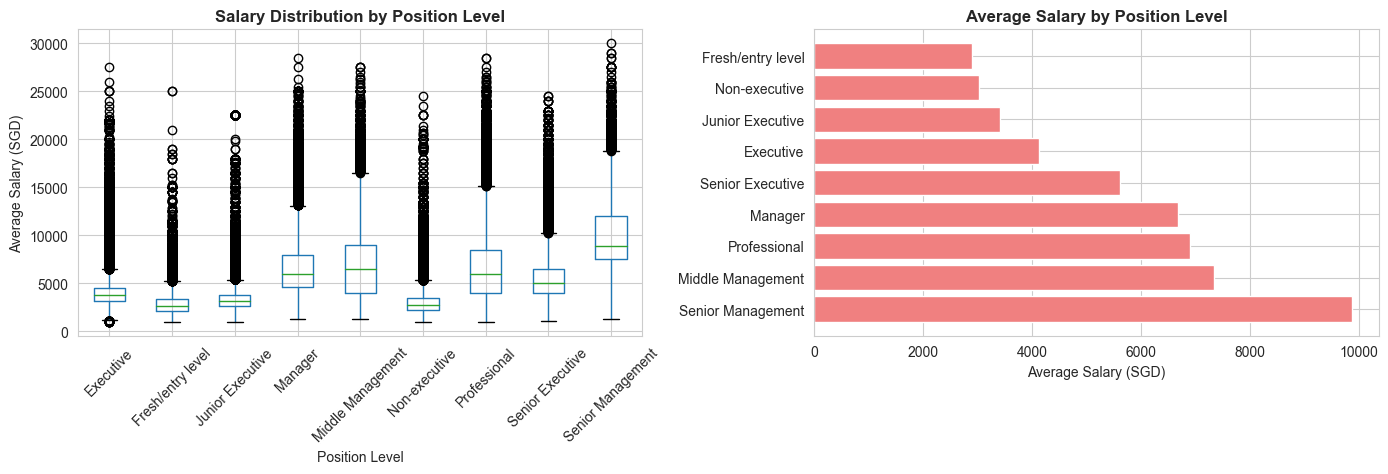

In [14]:
# Salary by position level
salary_by_level = df_filtered.groupby('positionLevels').agg({
    'average_salary': ['mean', 'median', 'std', 'count']
}).round(0).sort_values(('average_salary', 'mean'), ascending=False)

print("Salary by Position Level:")
print(salary_by_level)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
df_filtered.boxplot(column='average_salary', by='positionLevels', ax=axes[0])
axes[0].set_title('Salary Distribution by Position Level', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Position Level')
axes[0].set_ylabel('Average Salary (SGD)')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Bar chart of mean salaries
salary_means = df_filtered.groupby('positionLevels')['average_salary'].mean().sort_values(ascending=False)
axes[1].barh(salary_means.index, salary_means.values, color='lightcoral')
axes[1].set_title('Average Salary by Position Level', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Salary (SGD)')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 5. CATEGORY-BASED HIRING PATTERNS & COMPETITION
Note: Company names are mostly recruitment firms (intermediaries), so we focus on job categories instead.

In [15]:
# Category-based analysis (companies are mostly recruitment firms - not useful)
# Assign primary category (first listed) to each job
df_filtered['primary_category'] = df_filtered['category_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# Category hiring stats
category_stats = df_filtered.groupby('primary_category').agg({
    'title': 'count',
    'average_salary': 'mean',
    'numberOfVacancies': 'sum',
    'metadata_totalNumberJobApplication': 'mean',
    'metadata_totalNumberOfView': 'mean',
    'metadata_repostCount': 'mean'
}).rename(columns={'title': 'Num_Postings'}).sort_values('Num_Postings', ascending=False)

print("Top 15 Categories - Detailed Stats:")
print(category_stats.head(15).round(1))

# HIGH COMPETITION ROLES - identify categories with most applications
print("\n\nHIGH COMPETITION CATEGORIES (Highest avg applications per posting):")
high_comp = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_totalNumberJobApplication', ascending=False)
print(high_comp[['Num_Postings', 'metadata_totalNumberJobApplication', 'average_salary']].head(10).round(1))

Top 15 Categories - Detailed Stats:
                                  Num_Postings  average_salary  \
primary_category                                                 
Admin / Secretarial                      99399          3178.3   
Engineering                              98109          4894.6   
Information Technology                   97890          7108.8   
Accounting / Auditing / Taxation         77252          4311.5   
Building and Construction                72289          4616.2   
Customer Service                         62699          3420.0   
F&B                                      57980          3800.2   
Banking and Finance                      45193          7315.9   
Logistics / Supply Chain                 43853          3931.2   
Education and Training                   33518          3896.8   
Others                                   33170          4387.8   
Healthcare / Pharmaceutical              32331          4297.5   
Sales / Retail                          

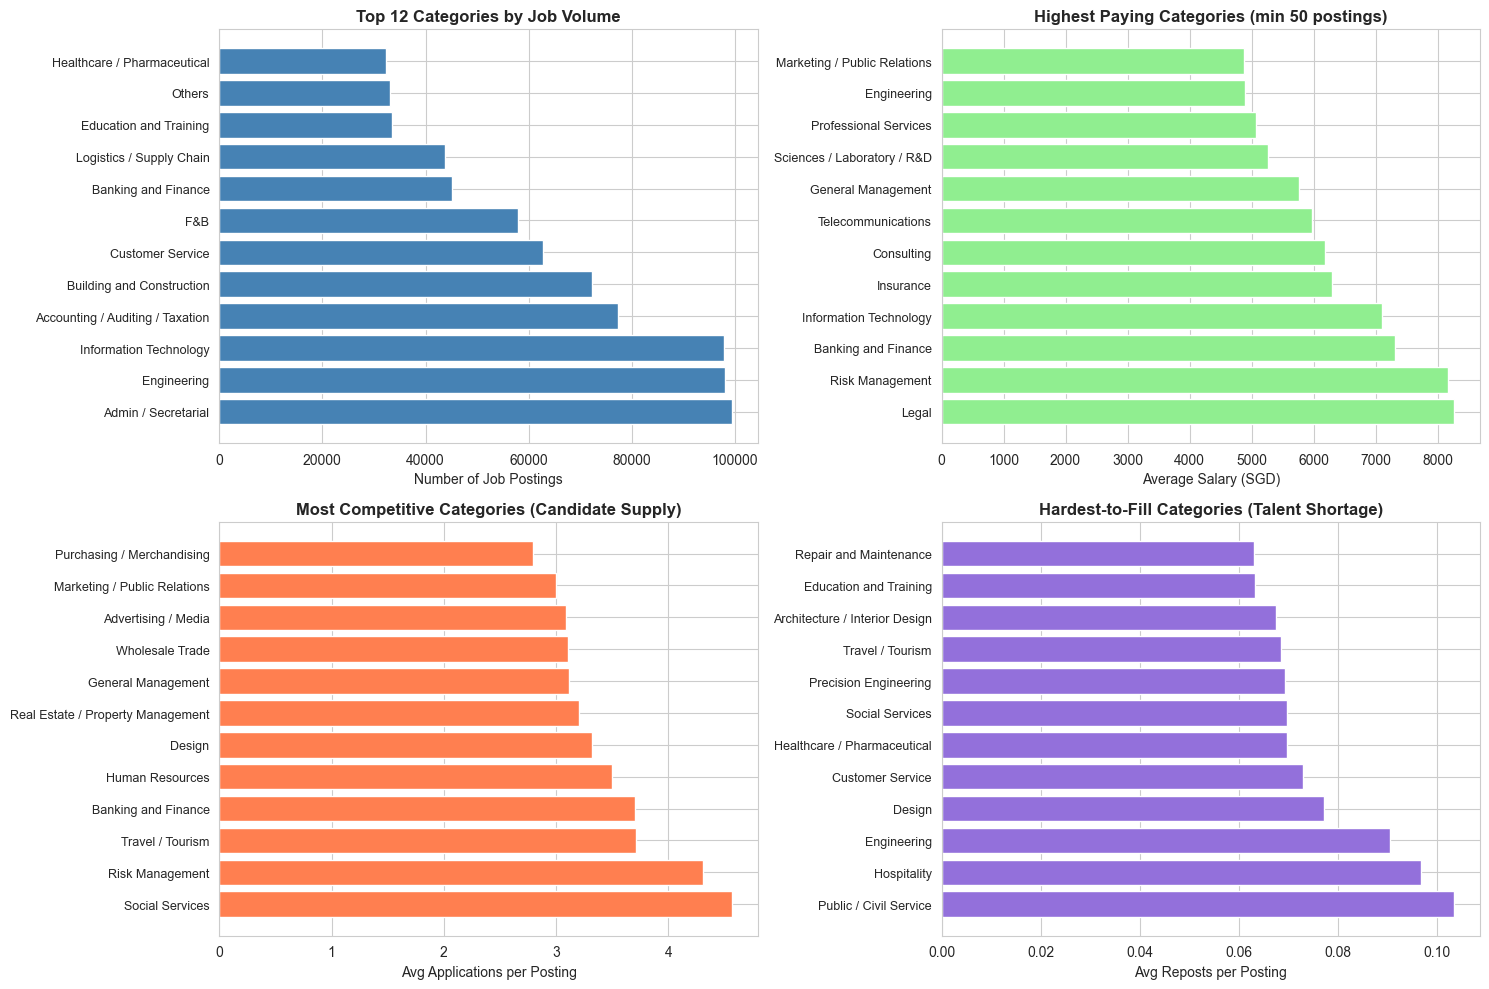


INSIGHT: Categories with HIGH candidate supply (easy to fill) vs HIGH repost (hard to fill)
This gap = where headhunters can add most value


In [16]:
# Visualize category-based patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top categories by number of postings
top_cats = category_stats.head(12)
axes[0, 0].barh(range(len(top_cats)), top_cats['Num_Postings'].values, color='steelblue')
axes[0, 0].set_yticks(range(len(top_cats)))
axes[0, 0].set_yticklabels(top_cats.index, fontsize=9)
axes[0, 0].set_xlabel('Number of Job Postings')
axes[0, 0].set_title('Top 12 Categories by Job Volume', fontweight='bold')

# Average salary by category
salary_by_cat = category_stats[category_stats['Num_Postings'] >= 50].sort_values('average_salary', ascending=False).head(12)
axes[0, 1].barh(range(len(salary_by_cat)), salary_by_cat['average_salary'].values, color='lightgreen')
axes[0, 1].set_yticks(range(len(salary_by_cat)))
axes[0, 1].set_yticklabels(salary_by_cat.index, fontsize=9)
axes[0, 1].set_xlabel('Average Salary (SGD)')
axes[0, 1].set_title('Highest Paying Categories (min 50 postings)', fontweight='bold')

# Competition intensity: applications per posting by category
comp_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_totalNumberJobApplication', ascending=False).head(12)
axes[1, 0].barh(range(len(comp_cats)), comp_cats['metadata_totalNumberJobApplication'].values, color='coral')
axes[1, 0].set_yticks(range(len(comp_cats)))
axes[1, 0].set_yticklabels(comp_cats.index, fontsize=9)
axes[1, 0].set_xlabel('Avg Applications per Posting')
axes[1, 0].set_title('Most Competitive Categories (Candidate Supply)', fontweight='bold')

# Hard-to-fill by category (highest repost rates)
repost_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_repostCount', ascending=False).head(12)
axes[1, 1].barh(range(len(repost_cats)), repost_cats['metadata_repostCount'].values, color='mediumpurple')
axes[1, 1].set_yticks(range(len(repost_cats)))
axes[1, 1].set_yticklabels(repost_cats.index, fontsize=9)
axes[1, 1].set_xlabel('Avg Reposts per Posting')
axes[1, 1].set_title('Hardest-to-Fill Categories (Talent Shortage)', fontweight='bold')

plt.tight_layout()
plt.show()

# Print insight on high competition
print("\nINSIGHT: Categories with HIGH candidate supply (easy to fill) vs HIGH repost (hard to fill)")
print("This gap = where headhunters can add most value")

## 6. JOB ATTRACTIVENESS & CANDIDATE ENGAGEMENT METRICS

Rows with valid original_post_date: 1,015,868 / 1,015,868

Date Range (Original Posting):
From: 2022-10-03 00:00:00
To:   2024-05-29 00:00:00
Span: 3 years, 20 months

Peak months (top 5):


,Postings
2023-08,81361
2023-07,80431
2024-04,79413
2024-01,78502
2023-10,77947


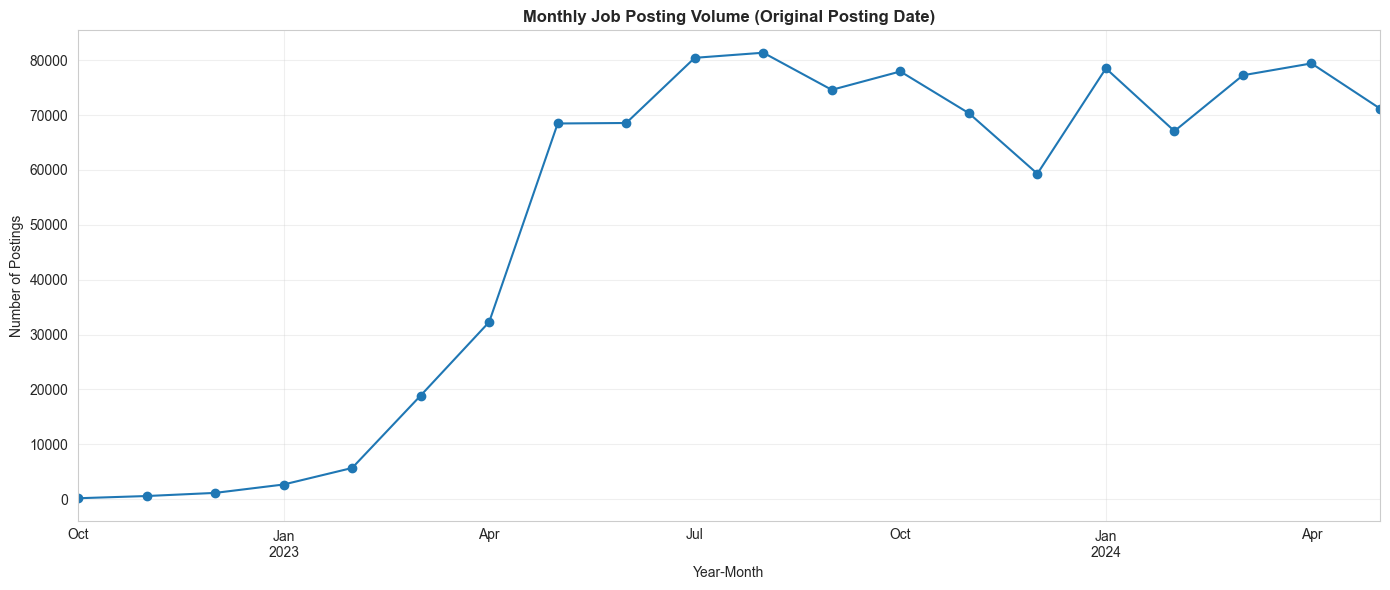

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # type: ignore

# Parse dates (coerce errors to NaT)
df_filtered['original_post_date'] = pd.to_datetime(df_filtered['metadata_originalPostingDate'], errors='coerce')
df_filtered['new_post_date'] = pd.to_datetime(df_filtered['metadata_newPostingDate'], errors='coerce')
df_filtered['expiry_date'] = pd.to_datetime(df_filtered['metadata_expiryDate'], errors='coerce')

# Drop rows with completely invalid original dates (small % usually)
print(f"Rows with valid original_post_date: {df_filtered['original_post_date'].notna().sum():,} / {len(df_filtered):,}")
df_temporal = df_filtered[df_filtered['original_post_date'].notna()].copy()

# Extract time features
df_temporal['year_month'] = df_temporal['original_post_date'].dt.to_period('M') # type: ignore
df_temporal['year'] = df_temporal['original_post_date'].dt.year # type: ignore
df_temporal['quarter'] = df_temporal['original_post_date'].dt.to_period('Q') # type: ignore
df_temporal['month'] = df_temporal['original_post_date'].dt.month # type: ignore

# Date range
print("\nDate Range (Original Posting):")
print(f"From: {df_temporal['original_post_date'].min()}")
print(f"To:   {df_temporal['original_post_date'].max()}")
print(f"Span: {df_temporal['year'].nunique()} years, {df_temporal['year_month'].nunique()} months")

# Overall monthly posting volume
monthly_volume = df_temporal['year_month'].value_counts().sort_index()
print("\nPeak months (top 5):")
display(monthly_volume.nlargest(5).to_frame('Postings'))

# Plot overall trend
plt.figure(figsize=(14, 6))
monthly_volume.plot(kind='line', marker='o')
plt.title('Monthly Job Posting Volume (Original Posting Date)', fontweight='bold')
plt.ylabel('Number of Postings')
plt.xlabel('Year-Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Calculate engagement metrics
df_filtered['application_rate'] = (df_filtered['metadata_totalNumberJobApplication'] / df_filtered['metadata_totalNumberOfView'] * 100).round(2)
df_filtered['application_rate'] = df_filtered['application_rate'].fillna(0)

# Jobs with highest engagement
print("Jobs with Highest Application Rates (Most Attractive):")
engaging_jobs = df_filtered[df_filtered['metadata_totalNumberOfView'] > 50].nlargest(10, 'application_rate')[['title', 'application_rate', 'metadata_totalNumberOfView', 'metadata_totalNumberJobApplication', 'average_salary']]
print(engaging_jobs.to_string())

# Overall metrics
print(f"\n\nOVERALL ENGAGEMENT METRICS:")
print(f"Average Views per Job: {df_filtered['metadata_totalNumberOfView'].mean():.0f}")
print(f"Average Applications per Job: {df_filtered['metadata_totalNumberJobApplication'].mean():.1f}")
print(f"Average Application Rate: {df_filtered['application_rate'].mean():.2f}%")
print(f"\nJobs with 0 Applications: {len(df_filtered[df_filtered['metadata_totalNumberJobApplication'] == 0])}")
print(f"Jobs with 0 Views: {len(df_filtered[df_filtered['metadata_totalNumberOfView'] == 0])}")

Jobs with Highest Application Rates (Most Attractive):
                                                                               title  application_rate  metadata_totalNumberOfView  metadata_totalNumberJobApplication  average_salary
171555                                                             SAFTY COORDINATOR             38.61                         158                                  61          3900.0
60258   System Analyst/ Business Analyst (IT/ No Coding / Hybrid WFH/ High Bonus) JO             37.23                         231                                  86          7000.0
119117                                          HSE Engineer (F&B Manufacturing MNC)             37.08                          89                                  33          6000.0
140814                                                               General Manager             35.36                         263                                  93         10000.0
459350                        

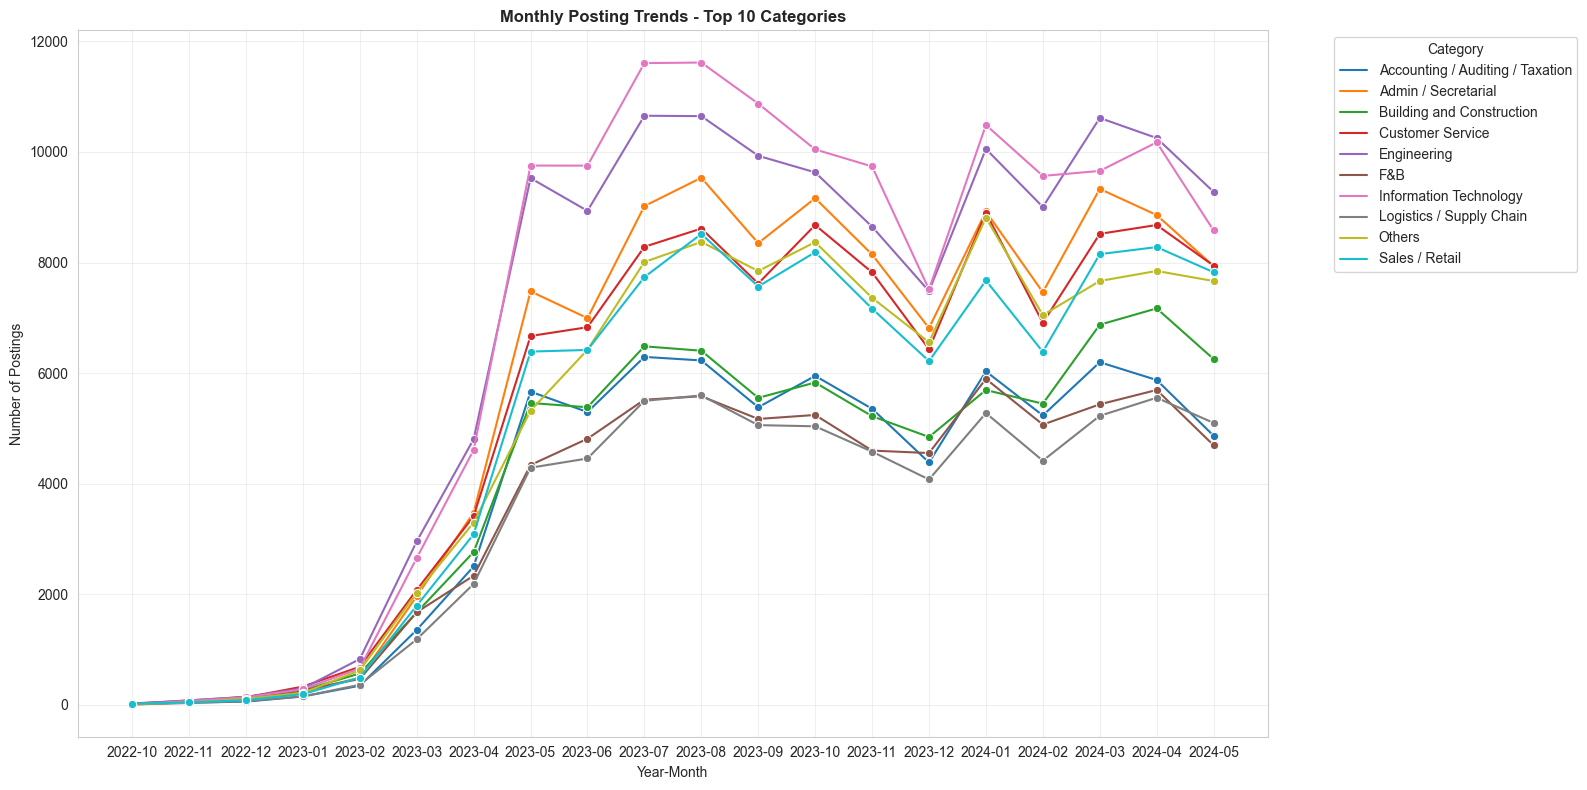

=== Quarterly Posting Volumes (Overall) ===

2023Q2: 278,925 
2023Q3: 402,469 
2023Q4: 353,067 
2024Q1: 379,681 

=== QoQ Growth by Category ===

2023-Q2 to 2023-Q3
Overall QoQ growth: +44.3% (278,925 → 402,469 postings)

Top 10 Growing Categories (2023-Q2 to 2023-Q3):


,Prev,Next,Growth %
category_list,,,
Public / Civil Service,417,806,93.285372
Social Services,1009,1865,84.836472
Real Estate / Property Management,1638,2761,68.559219
Environment / Health,2649,4368,64.892412
Entertainment,612,1009,64.869281
Others,15042,24230,61.082303
Hospitality,3847,5941,54.432025
Travel / Tourism,1048,1610,53.625954
Medical / Therapy Services,2302,3526,53.171156



Top 10 Declining Categories (2023-Q2 to 2023-Q3):


,Prev,Next,Growth %
category_list,,,
General Management,5888,8057,36.837636
Design,3163,4305,36.104964
Telecommunications,1374,1863,35.589520
Building and Construction,13609,18444,35.527959
Sciences / Laboratory / R&D,3003,4057,35.098235
Engineering,23268,31234,34.235860
Accounting / Auditing / Taxation,13467,17907,32.969481
Wholesale Trade,1790,2360,31.843575
Manufacturing,9843,12832,30.366758



------------------------------------------------------------

2023-Q3 to 2023-Q4
Overall QoQ growth: -12.3% (402,469 → 353,067 postings)

Top 10 Growing Categories (2023-Q3 to 2023-Q4):


,Prev,Next,Growth %
category_list,,,
Social Services,1865,2246,20.428954
Sciences / Laboratory / R&D,4057,4250,4.757210
Education and Training,9755,9680,-0.768836
Healthcare / Pharmaceutical,11292,11144,-1.310662
Precision Engineering,1432,1352,-5.586592
Customer Service,24521,22933,-6.476082
Public / Civil Service,806,753,-6.575682
Advertising / Media,4107,3836,-6.598490
Human Resources,12137,11211,-7.629562



Top 10 Declining Categories (2023-Q3 to 2023-Q4):


,Prev,Next,Growth %
category_list,,,
Manufacturing,12832,10598,-17.409601
Engineering,31234,25763,-17.516168
Insurance,1799,1463,-18.677043
Design,4305,3454,-19.767712
Hospitality,5941,4766,-19.777815
Information Technology,34098,27299,-19.939586
Environment / Health,4368,3441,-21.222527
Entertainment,1009,770,-23.686819
Purchasing / Merchandising,4032,2936,-27.182540



------------------------------------------------------------

2023-Q4 to 2024-Q1
Overall QoQ growth: +7.5% (353,067 → 379,681 postings)

Top 10 Growing Categories (2023-Q4 to 2024-Q1):


,Prev,Next,Growth %
category_list,,,
Wholesale Trade,2044,2538,24.168297
Hospitality,4766,5669,18.946706
Manufacturing,10598,12435,17.333459
Precision Engineering,1352,1575,16.494083
Entertainment,770,896,16.363636
General Work,5723,6626,15.778438
Engineering,25763,29675,15.184567
F&B,14399,16402,13.910688
Professional Services,3921,4465,13.874012



Top 10 Declining Categories (2023-Q4 to 2024-Q1):


,Prev,Next,Growth %
category_list,,,
Architecture / Interior Design,3048,3113,2.132546
Environment / Health,3441,3496,1.598373
Advertising / Media,3836,3888,1.355579
Banking and Finance,12474,12524,0.400834
Travel / Tourism,1370,1365,-0.364964
Legal,2329,2285,-1.889223
Purchasing / Merchandising,2936,2817,-4.053134
Education and Training,9680,9130,-5.681818
Public / Civil Service,753,685,-9.030544



------------------------------------------------------------



In [19]:
# Explode for multi-category analysis (each posting contributes to all its categories)
df_exploded = df_temporal.explode('category_list')
df_exploded = df_exploded[df_exploded['category_list'].str.strip() != '']

# Monthly volume by category
cat_monthly = df_exploded.groupby(['year_month', 'category_list']).size().reset_index(name='postings')
cat_monthly['year_month'] = cat_monthly['year_month'].astype(str)  # for plotting

# Top 10 categories overall for focused plotting
top_cats = df_exploded['category_list'].value_counts().head(10).index

cat_monthly_top = cat_monthly[cat_monthly['category_list'].isin(top_cats)]

# Pivot for line plot
pivot_cat = cat_monthly_top.pivot(index='year_month', columns='category_list', values='postings').fillna(0)

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(data=pivot_cat, dashes=False, marker='o')
plt.title('Monthly Posting Trends - Top 10 Categories', fontweight='bold')
plt.ylabel('Number of Postings')
plt.xlabel('Year-Month')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Fixed QoQ growth code - corrected MultiIndex access
quarters = ['2023Q2', '2023Q3', '2023Q4', '2024Q1']
transitions = [
    ('2023-Q2 to 2023-Q3', '2023Q2', '2023Q3'),
    ('2023-Q3 to 2023-Q4', '2023Q3', '2023Q4'),
    ('2023-Q4 to 2024-Q1', '2023Q4', '2024Q1')
]

# Use exploded df
df_exploded = df_temporal.explode('category_list')
df_exploded = df_exploded[df_exploded['category_list'].str.strip() != '']
df_exploded['quarter_str'] = df_exploded['quarter'].astype(str)

# Overall quarterly volumes
quarterly_counts = df_exploded.groupby('quarter_str').size()

print("=== Quarterly Posting Volumes (Overall) ===\n")
for q in quarters:
    count = quarterly_counts.get(q, 0)
    # note = " (partial: only Jun)" if q == '2023Q2' else " (full)"
    print(f"{q}: {count:,} ")

# Category-level quarterly volumes (MultiIndex Series)
quarterly_cat = df_exploded.groupby(['quarter_str', 'category_list']).size()

print("\n=== QoQ Growth by Category ===\n")

for label, prev_q, next_q in transitions:
    prev_count_total = quarterly_counts.get(prev_q, 0)
    next_count_total = quarterly_counts.get(next_q, 0)
    
    overall_growth = ((next_count_total - prev_count_total) / prev_count_total * 100 
                      if prev_count_total > 0 else float('nan'))
    
    print(f"{label}")
    print(f"Overall QoQ growth: {overall_growth:+.1f}% "
          f"({prev_count_total:,} → {next_count_total:,} postings)")
    
    # Correct MultiIndex access using .loc with IndexSlice
    import pandas as pd
    
    prev_cat = quarterly_cat.loc[pd.IndexSlice[prev_q, :]] if prev_q in quarterly_cat.index.levels[0] else pd.Series() # type: ignore
    next_cat = quarterly_cat.loc[pd.IndexSlice[next_q, :]] if next_q in quarterly_cat.index.levels[0] else pd.Series() # type: ignore
    
    # Align indexes (categories)
    all_cats = prev_cat.index.union(next_cat.index)
    prev_cat = prev_cat.reindex(all_cats, fill_value=0)
    next_cat = next_cat.reindex(all_cats, fill_value=0)
    
    qoq_df = pd.DataFrame({
        'Prev': prev_cat,
        'Next': next_cat
    })
    
    qoq_df['Growth %'] = ((qoq_df['Next'] - qoq_df['Prev']) / 
                         qoq_df['Prev'].replace(0, 1)) * 100  # avoid div-by-zero
    
    qoq_df = qoq_df.sort_values('Growth %', ascending=False)
    
    # Filter meaningful volume
    qoq_df = qoq_df[(qoq_df['Prev'] >= 100) | (qoq_df['Next'] >= 100)]
    
    print(f"\nTop 10 Growing Categories ({label}):")
    display(qoq_df.head(10))
    
    print(f"\nTop 10 Declining Categories ({label}):")
    display(qoq_df.tail(10))
    
    print("\n" + "-"*60 + "\n")

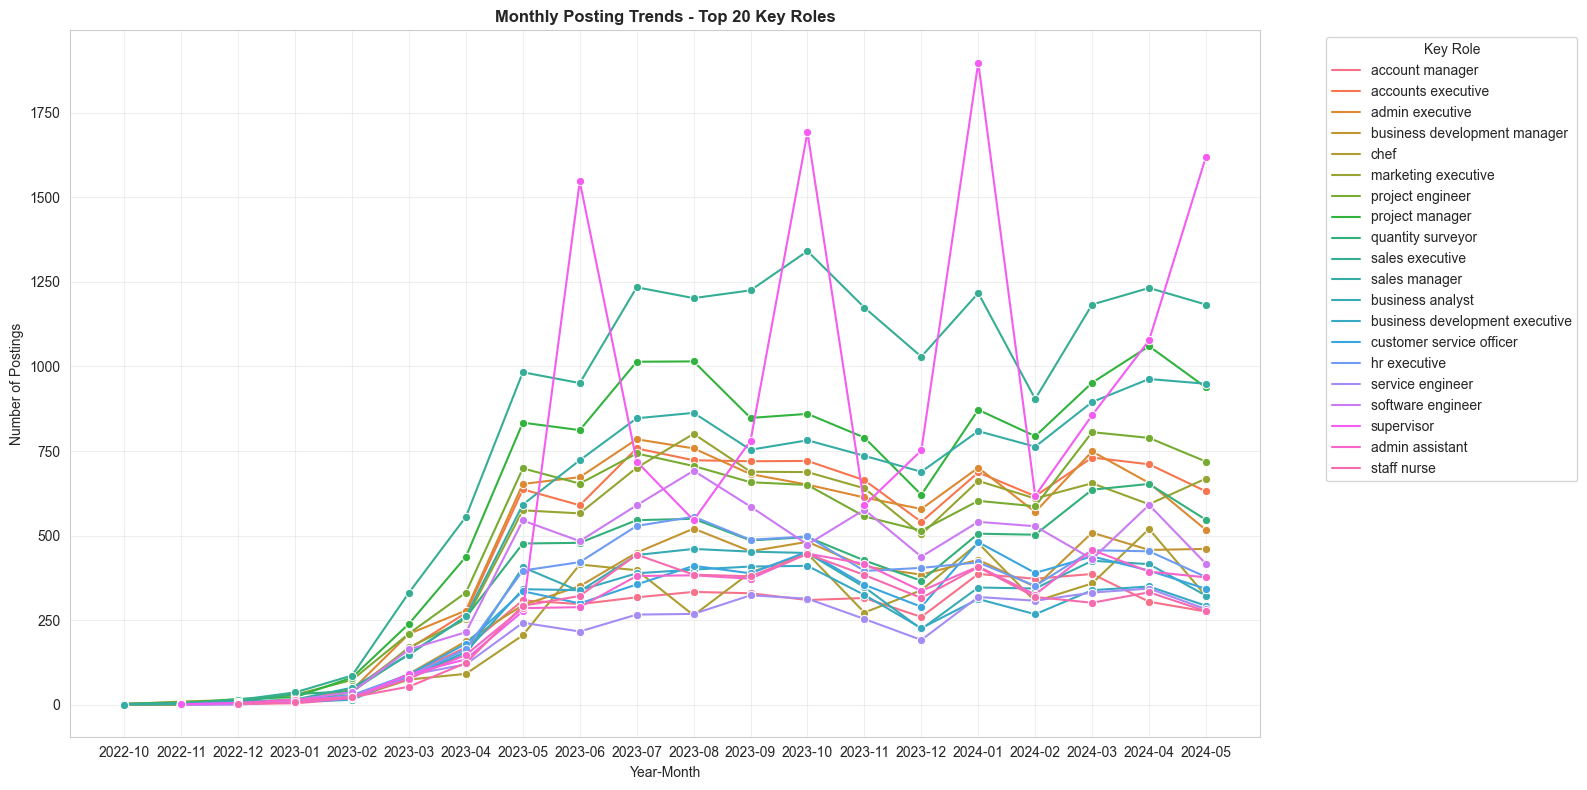

Emerging Roles (highest relative share increase in recent years):


,Relative Growth Factor
key_role,
0 3yrs exp,1.0
principal strategy and,1.0
principal trading risk,1.0
principal test engineer,1.0
principal test development,1.0
principal telecoms consulting,1.0
principal technology consultant,1.0
principal technologist ikr,1.0
principal technician nsy,1.0


=== Quarterly Posting Volumes (Overall) ===

2023Q2: 169,309 
2023Q3: 236,387 
2023Q4: 207,602 
2024Q1: 222,834 
Emerging Roles (highest relative share increase in recent years):


,Relative Growth Factor
key_role,
0 3yrs exp,1.0
principal strategy and,1.0
principal trading risk,1.0
principal test engineer,1.0
principal test development,1.0
principal telecoms consulting,1.0
principal technology consultant,1.0
principal technologist ikr,1.0
principal technician nsy,1.0



=== QoQ Growth by Category ===

2023-Q2 to 2023-Q3
Overall QoQ growth: +39.6% (169,309 → 236,387 postings)

Top 10 Growing Key Roles (2023-Q2 to 2023-Q3):


,Prev,Next,Growth %
key_role,,,
temp accounts assistant,1,118,11700.000000
senior purchaser 1,0,102,10200.000000
senior buyer oil,0,100,10000.000000
procurement officer,16,125,681.250000
bank officer gl,15,103,586.666667
site officer training,18,116,544.444444
marketing assistant manager,24,147,512.500000
sales assistant manager,29,159,448.275862
logistics officer,24,114,375.000000



Top 10 Declining Key Roles (2023-Q2 to 2023-Q3):


,Prev,Next,Growth %
key_role,,,
sales and marketing,138,118,-14.492754
administrator,118,100,-15.254237
sales assistant,111,77,-30.630631
operations supervisor,329,209,-36.474164
call centre officer,136,84,-38.235294
maintenance engineer,131,79,-39.694656
assistant supervisor,113,65,-42.477876
e i engineer,144,53,-63.194444
piping engineer water,187,65,-65.240642



------------------------------------------------------------

2023-Q3 to 2023-Q4
Overall QoQ growth: -12.2% (236,387 → 207,602 postings)

Top 10 Growing Key Roles (2023-Q3 to 2023-Q4):


,Prev,Next,Growth %
key_role,,,
web developer full,15,159,960.000000
admin operations executive,23,204,786.956522
tuition coordinator admin,24,204,750.000000
full time tuition,26,208,700.000000
e i engineer,53,149,181.132075
senior social worker,56,141,151.785714
operations marketing intern,78,157,101.282051
human resource and,68,117,72.058824
customer relations officer,68,114,67.647059



Top 10 Declining Key Roles (2023-Q3 to 2023-Q4):


,Prev,Next,Growth %
key_role,,,
euc engineer,308,106,-65.584416
bank officer gl,103,23,-77.669903
procurement officer,125,26,-79.200000
procurement specialist,118,23,-80.508475
temp accounts assistant,118,22,-81.355932
management trainee no,107,18,-83.177570
site officer training,116,0,-100.000000
senior purchaser 1,102,0,-100.000000
senior buyer oil,100,0,-100.000000



------------------------------------------------------------

2023-Q4 to 2024-Q1
Overall QoQ growth: +7.3% (207,602 → 222,834 postings)

Top 10 Growing Key Roles (2023-Q4 to 2024-Q1):


,Prev,Next,Growth %
key_role,,,
financial advisor,20,119,495.000000
sales admin assistant,37,116,213.513514
sales support admin,48,145,202.083333
mechanic,43,104,141.860465
supply chain executive,55,123,123.636364
assistant finance manager,98,200,104.081633
purchasing assistant,59,118,100.000000
engineering manager,51,102,100.000000
consultant,53,102,92.452830



Top 10 Declining Key Roles (2023-Q4 to 2024-Q1):


,Prev,Next,Growth %
key_role,,,
retail sales associate,161,112,-30.434783
english language teacher,118,81,-31.355932
senior mechanical engineer,119,80,-32.773109
senior finance executive,106,69,-34.905660
temp admin assistant,343,220,-35.860058
cnc machinist,112,71,-36.607143
euc engineer,106,66,-37.735849
digital marketing manager,114,56,-50.877193
corporate secretarial executive,111,54,-51.351351



------------------------------------------------------------



In [20]:
# Top 20 roles overall
top_roles = df_temporal['key_role'].value_counts().head(20).index

role_monthly = df_temporal[df_temporal['key_role'].isin(top_roles)].groupby(['year_month', 'key_role']).size().reset_index(name='postings')
role_monthly['year_month'] = role_monthly['year_month'].astype(str)

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(data=role_monthly, x='year_month', y='postings', hue='key_role', marker='o')
plt.title('Monthly Posting Trends - Top 20 Key Roles', fontweight='bold')
plt.ylabel('Number of Postings')
plt.xlabel('Year-Month')
plt.legend(title='Key Role', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Emerging roles: roles with strongest growth in recent period
recent_period = df_temporal['year'] >= (df_temporal['year'].max() - 2)  # last ~2-3 years
emerging = df_temporal[recent_period].groupby('key_role').size()
all_time = df_temporal.groupby('key_role').size()
growth_ratio = (emerging / emerging.sum()) / (all_time / all_time.sum())  # relative share increase
growth_ratio = growth_ratio.sort_values(ascending=False)

print("Emerging Roles (highest relative share increase in recent years):")
display(growth_ratio.head(20).to_frame('Relative Growth Factor'))

# Fixed QoQ growth code - corrected MultiIndex access
quarters = ['2023Q2', '2023Q3', '2023Q4', '2024Q1']
transitions = [
    ('2023-Q2 to 2023-Q3', '2023Q2', '2023Q3'),
    ('2023-Q3 to 2023-Q4', '2023Q3', '2023Q4'),
    ('2023-Q4 to 2024-Q1', '2023Q4', '2024Q1')
]

# Use exploded df
df_exploded = df_temporal.explode('key_role')
df_exploded = df_exploded[df_exploded['key_role'].str.strip() != '']
df_exploded['quarter_str'] = df_exploded['quarter'].astype(str)

# Overall quarterly volumes
quarterly_counts = df_exploded.groupby('quarter_str').size()

print("=== Quarterly Posting Volumes (Overall) ===\n")
for q in quarters:
    count = quarterly_counts.get(q, 0)
    # note = " (partial: only Jun)" if q == '2023Q2' else " (full)"
    print(f"{q}: {count:,} ")

# Category-level quarterly volumes (MultiIndex Series)
quarterly_cat = df_exploded.groupby(['quarter_str', 'key_role']).size()

# Emerging roles: roles with strongest growth in recent period
recent_period = df_temporal['year'] >= (df_temporal['year'].max() - 2)  # last ~2-3 years
emerging = df_temporal[recent_period].groupby('key_role').size()
all_time = df_temporal.groupby('key_role').size()
growth_ratio = (emerging / emerging.sum()) / (all_time / all_time.sum())  # relative share increase
growth_ratio = growth_ratio.sort_values(ascending=False)

print("Emerging Roles (highest relative share increase in recent years):")
display(growth_ratio.head(20).to_frame('Relative Growth Factor'))

print("\n=== QoQ Growth by Category ===\n")

for label, prev_q, next_q in transitions:
    prev_count_total = quarterly_counts.get(prev_q, 0)
    next_count_total = quarterly_counts.get(next_q, 0)
    
    overall_growth = ((next_count_total - prev_count_total) / prev_count_total * 100 
                      if prev_count_total > 0 else float('nan'))
    
    print(f"{label}")
    print(f"Overall QoQ growth: {overall_growth:+.1f}% "
          f"({prev_count_total:,} → {next_count_total:,} postings)")
    
    # Correct MultiIndex access using .loc with IndexSlice
    import pandas as pd
    
    prev_cat = quarterly_cat.loc[pd.IndexSlice[prev_q, :]] if prev_q in quarterly_cat.index.levels[0] else pd.Series() # type: ignore
    next_cat = quarterly_cat.loc[pd.IndexSlice[next_q, :]] if next_q in quarterly_cat.index.levels[0] else pd.Series() # type: ignore
    
    # Align indexes (categories)
    all_cats = prev_cat.index.union(next_cat.index)
    prev_cat = prev_cat.reindex(all_cats, fill_value=0)
    next_cat = next_cat.reindex(all_cats, fill_value=0)
    
    qoq_df = pd.DataFrame({
        'Prev': prev_cat,
        'Next': next_cat
    })
    
    qoq_df['Growth %'] = ((qoq_df['Next'] - qoq_df['Prev']) / 
                         qoq_df['Prev'].replace(0, 1)) * 100  # avoid div-by-zero
    
    qoq_df = qoq_df.sort_values('Growth %', ascending=False)
    
    # Filter meaningful volume
    qoq_df = qoq_df[(qoq_df['Prev'] >= 100) | (qoq_df['Next'] >= 100)]
    
    print(f"\nTop 10 Growing Key Roles ({label}):")
    display(qoq_df.head(10))
    
    print(f"\nTop 10 Declining Key Roles ({label}):")
    display(qoq_df.tail(10))
    
    print("\n" + "-"*60 + "\n")

In [21]:
from scipy.stats import linregress 
import numpy as np

# Ensure date parsing and features (run if not already done)
df_filtered['original_post_date'] = pd.to_datetime(df_filtered['metadata_originalPostingDate'], errors='coerce')
df_temporal = df_filtered[df_filtered['original_post_date'].notna()].copy()
df_temporal['year_month'] = df_temporal['original_post_date'].dt.to_period('M') # type: ignore

# Explode categories (assuming you have category_list from earlier expansion)
# If not, add: df_temporal['category_list'] = df_temporal['categories'].str.split('|')
df_exploded = df_temporal.explode('category_list')
df_exploded = df_exploded[df_exploded['category_list'].notna() & (df_exploded['category_list'].str.strip() != '')]

# Ensure key_role is cleaned (reuse or add your cleaning function)
# ... [paste your clean_title function here if needed]
df_exploded['key_role'] = df_exploded['title'].apply(clean_title)

# All unique months in the data (for consistent time axis)
all_months = sorted(df_exploded['year_month'].unique())
month_to_num = {month: idx for idx, month in enumerate(all_months)}

print(f"Time span: {all_months[0]} to {all_months[-1]} ({len(all_months)} months)")
print(f"Unique key_roles: {df_exploded['key_role'].nunique():,}")
print(f"Unique categories: {df_exploded['category_list'].nunique()}")
print(f"Total role × category pairs: {df_exploded.groupby(['key_role', 'category_list']).ngroups:,}")

Time span: 2022-10 to 2024-05 (20 months)
Unique key_roles: 222,976
Unique categories: 43
Total role × category pairs: 442,868


In [22]:
# Pre-filter significant pairs by total volume
pair_totals = df_exploded.groupby(['key_role', 'category_list']).size()
significant_pairs = pair_totals[pair_totals >= 50].index

trends = []

for key_role, category in significant_pairs:
    subset = df_exploded[(df_exploded['key_role'] == key_role) & 
                         (df_exploded['category_list'] == category)]
    
    # Monthly counts, reindexed to all months (gaps = 0)
    monthly = subset['year_month'].value_counts().reindex(all_months, fill_value=0)
    
    # Skip if not enough temporal coverage
    if (monthly > 0).sum() < 6:
        continue
    
    x = np.arange(len(monthly))
    y = monthly.values
    
    slope, intercept, r_value, _, _ = linregress(x, y)
    mean_y = y.mean()
    relative_slope = slope / mean_y if mean_y > 0 else 0
    
    trends.append({
        'key_role': key_role,
        'category': category,
        'total_postings': int(y.sum()),
        'months_active': int((monthly > 0).sum()),
        'avg_monthly': round(mean_y, 1),
        'slope': round(slope, 2),                  # postings/month # type: ignore
        'relative_slope': round(relative_slope, 3), # fractional growth/month
        'annual_growth_est': round(slope * 12, 1),  # rough annual volume change # type: ignore
        'r_squared': round(r_value**2, 3) # type: ignore
    })

df_trends = pd.DataFrame(trends)

# Filter for reasonably reliable trends
df_trends = df_trends[df_trends['r_squared'] >= 0.2].sort_values('relative_slope', ascending=False)

print(f"Significant role × category pairs analyzed: {len(df_trends):,}")
print(f"Time span used: {len(all_months)} months")

Significant role × category pairs analyzed: 2,683
Time span used: 20 months


In [23]:
print("=== Top 25 Growing Role × Category Pairs ===")
display(df_trends.head(25)[['key_role', 'category', 'total_postings', 'avg_monthly', 
                           'relative_slope', 'annual_growth_est', 'r_squared']])

=== Top 25 Growing Role × Category Pairs ===


,key_role,category,total_postings,avg_monthly,relative_slope,annual_growth_est,r_squared
1758,marketing intern,Admin / Secretarial,136,6.8,0.263,21.4,0.272
935,digital marketing manager,Sales / Retail,75,3.8,0.258,11.6,0.305
936,digital marketing professional,Marketing / Public Relations,64,3.2,0.256,9.8,0.312
932,digital marketing manager,Consulting,71,3.6,0.255,10.9,0.297
539,business executive,Advertising / Media,63,3.2,0.247,9.3,0.340
171,admin hr,Admin / Secretarial,224,11.2,0.247,33.2,0.384
2843,senior carpenter,General Work,61,3.0,0.247,9.0,0.445
540,business executive,Consulting,64,3.2,0.244,9.4,0.319
2439,r d chemist,Sciences / Laboratory / R&D,78,3.9,0.236,11.1,0.403
1733,marketing communication manager,Marketing / Public Relations,71,3.6,0.236,10.0,0.333


In [24]:
print("=== Top 25 Shrinking Role × Category Pairs ===")
display(df_trends.tail(25)[['key_role', 'category', 'total_postings', 'avg_monthly', 
                            'relative_slope', 'annual_growth_est', 'r_squared']])

=== Top 25 Shrinking Role × Category Pairs ===


,key_role,category,total_postings,avg_monthly,relative_slope,annual_growth_est,r_squared
950,document controller,Admin / Secretarial,200,10.0,0.061,7.4,0.240
1251,frontend developer,Information Technology,151,7.6,0.061,5.5,0.224
126,admin assistant,Logistics / Supply Chain,142,7.1,0.061,5.2,0.224
2260,project coordinator,Information Technology,75,3.8,0.060,2.7,0.221
508,business development executive,Information Technology,166,8.3,0.060,5.9,0.222
664,cleaner,F&B,91,4.6,0.060,3.3,0.218
2938,senior process engineer,Engineering,206,10.3,0.060,7.5,0.206
3445,warehouse executive,Logistics / Supply Chain,187,9.4,0.060,6.7,0.215
2682,sales executive,Information Technology,209,10.4,0.060,7.6,0.268
85,accounts executive,Building and Construction,185,9.2,0.060,6.6,0.263


In [25]:
top_growing = df_trends.head(5)

print("=== Predicted Next 12-Month Postings for Top 5 Growing Pairs ===")
for _, row in top_growing.iterrows():
    # Re-build monthly series for this pair
    subset = df_exploded[(df_exploded['key_role'] == row['key_role']) & 
                         (df_exploded['category_list'] == row['category'])]
    monthly = subset['year_month'].value_counts().reindex(all_months, fill_value=0)
    x_historical = np.arange(len(monthly))
    y_historical = monthly.values
    
    slope = row['slope']
    intercept = y_historical.mean() - slope * x_historical.mean()  # rough intercept
    
    # Future x values
    x_future = np.arange(len(monthly), len(monthly) + 12)
    predicted = np.maximum(slope * x_future + intercept, 0)  # no negative postings
    
    print(f"\n{row['key_role']} in {row['category']}")
    print(f"Current avg monthly: {row['avg_monthly']:.1f} → Estimated next 12-month total: {predicted.sum():.0f} "
          f"(avg {predicted.mean():.1f}/month)")

=== Predicted Next 12-Month Postings for Top 5 Growing Pairs ===

marketing intern in Admin / Secretarial
Current avg monthly: 6.8 → Estimated next 12-month total: 425 (avg 35.4/month)

digital marketing manager in Sales / Retail
Current avg monthly: 3.8 → Estimated next 12-month total: 231 (avg 19.3/month)

digital marketing professional in Marketing / Public Relations
Current avg monthly: 3.2 → Estimated next 12-month total: 196 (avg 16.3/month)

digital marketing manager in Consulting
Current avg monthly: 3.6 → Estimated next 12-month total: 217 (avg 18.1/month)

business executive in Advertising / Media
Current avg monthly: 3.2 → Estimated next 12-month total: 188 (avg 15.6/month)


## 7. EMPLOYMENT TYPE ANALYSIS

Employment Types:
Permanent                452169
Full Time                387785
Contract                 135005
Part Time                 19353
Temporary                 15728
Internship/Attachment      3478
Freelance                  1469
Flexi-work                  881
Name: employmentTypes, dtype: int64

Employment Type Analysis:
                      average_salary                 numberOfVacancies  \
                               count    mean  median              mean   
employmentTypes                                                          
Contract                      135005  5019.0  4200.0               3.1   
Flexi-work                       881  3723.5  3850.0               6.7   
Freelance                       1469  4177.2  3750.0               6.7   
Full Time                     387785  4632.5  3850.0               2.5   
Internship/Attachment           3478  2102.0  1500.0               2.6   
Part Time                      19353  3074.0  2650.0               4.4 

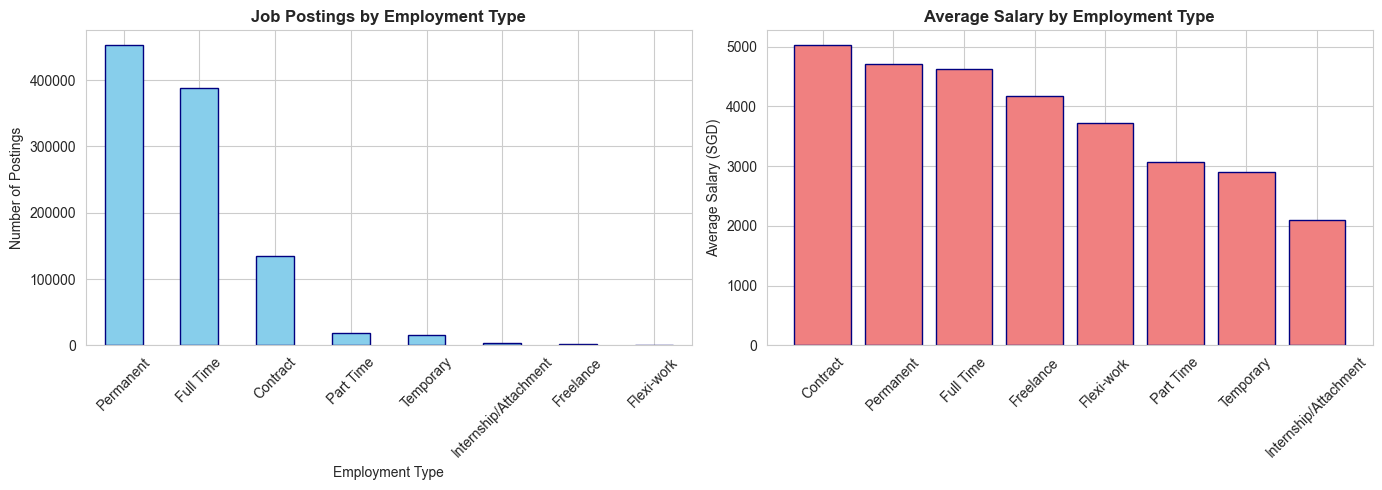

In [26]:
# Employment type breakdown
emp_type_counts = df_filtered['employmentTypes'].value_counts()
print("Employment Types:")
print(emp_type_counts)

# Salary and benefits by employment type
emp_analysis = df_filtered.groupby('employmentTypes').agg({
    'average_salary': ['count', 'mean', 'median'],
    'numberOfVacancies': 'mean',
    'metadata_totalNumberJobApplication': 'mean'
}).round(1)

print(f"\nEmployment Type Analysis:")
print(emp_analysis)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

emp_type_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='navy')
axes[0].set_title('Job Postings by Employment Type', fontweight='bold')
axes[0].set_ylabel('Number of Postings')
axes[0].set_xlabel('Employment Type')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

salary_by_emp = df_filtered.groupby('employmentTypes')['average_salary'].mean().sort_values(ascending=False)
axes[1].bar(range(len(salary_by_emp)), salary_by_emp.values, color='lightcoral', edgecolor='navy')
axes[1].set_xticks(range(len(salary_by_emp)))
axes[1].set_xticklabels(salary_by_emp.index, rotation=45)
axes[1].set_ylabel('Average Salary (SGD)')
axes[1].set_title('Average Salary by Employment Type', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. QUICK-TO-FILL vs HARD-TO-FILL ROLES

In [27]:
# Identify quick-to-fill roles (high applications, no reposts)
quick_fill = df_filtered[(df_filtered['metadata_totalNumberJobApplication'] > 10) & (df_filtered['metadata_repostCount'] == 0)].sort_values('metadata_totalNumberJobApplication', ascending=False)
print("QUICK-TO-FILL ROLES (High Demand, No Reposts):")
print(quick_fill[['title', 'metadata_totalNumberJobApplication', 'average_salary', 'employmentTypes']].head(10).to_string())

# Identify hard-to-fill roles (multiple reposts, few applications)
hard_fill = df_filtered[(df_filtered['metadata_repostCount'] > 1) | ((df_filtered['metadata_totalNumberJobApplication'] == 0) & (df_filtered['metadata_totalNumberOfView'] > 50))]
print(f"\n\nHARD-TO-FILL ROLES (Reposts or Low Response):")
print(hard_fill[['title', 'metadata_repostCount', 'metadata_totalNumberJobApplication', 'average_salary']].head(10).to_string())

# Category analysis for quick vs hard
print(f"\n\nAnalyzing Categories:")
print(f"Categories in QUICK-TO-FILL roles: {Counter([cat for cats in quick_fill['category_list'] for cat in cats]).most_common(5)}")
print(f"Categories in HARD-TO-FILL roles: {Counter([cat for cats in hard_fill['category_list'] for cat in cats]).most_common(5)}")

QUICK-TO-FILL ROLES (High Demand, No Reposts):
                                      title  metadata_totalNumberJobApplication  average_salary employmentTypes
130005  WFH Office Administrative Assistant                                1342          4000.0       Full Time
58349       WFH Appointment Setting Officer                                 922          3750.0       Part Time
94101                       Admin Assistant                                 785          4000.0       Full Time
96047                       Admin Assistant                                 708          4000.0       Full Time
146416     Admin Executive (Work From Home)                                 678          3000.0       Permanent
197369                      Admin Executive                                 663          4400.0       Full Time
54020        Office Administrator Assistant                                 629          4650.0       Permanent
5735                        ADMIN ASSISTANT              

## 9. SALARY-VACANCY RELATIONSHIP

Salary and Applications by Number of Vacancies:
                  average_salary         metadata_totalNumberJobApplication
                            mean   count                               mean
numberOfVacancies                                                          
54                        7064.6       6                                0.3
7                         5246.6    2286                                1.4
1                         4855.0  573100                                2.4
51                        4780.0       5                               11.2
15                        4734.5    2233                                2.1
...                          ...     ...                                ...
48                        2261.8      17                                0.2
400                       2035.0       4                                0.0
165                       2010.5       1                                0.0
111                       1900.0       1

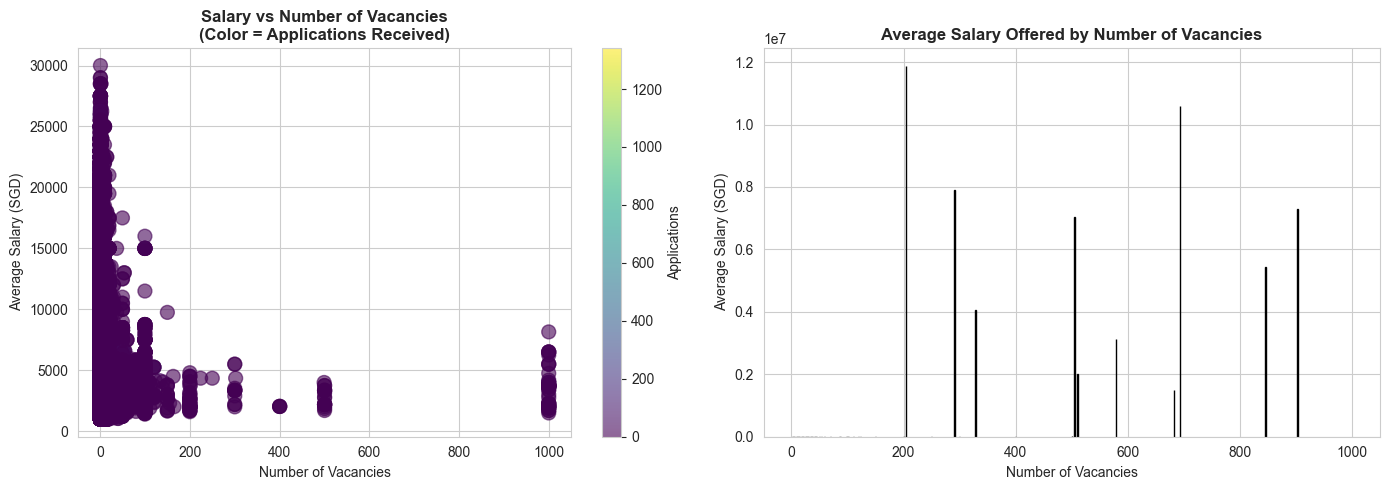

In [28]:
# Analyze relationship between salary and number of vacancies
salary_vacancy = df_filtered.groupby('numberOfVacancies').agg({
    'average_salary': ['mean', 'count'],
    'metadata_totalNumberJobApplication': 'mean'
}).round(1).sort_values(('average_salary', 'mean'), ascending=False)

print("Salary and Applications by Number of Vacancies:")
print(salary_vacancy)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: salary vs vacancies
axes[0].scatter(df_filtered['numberOfVacancies'], df_filtered['average_salary'], alpha=0.6, s=100, c=df_filtered['metadata_totalNumberJobApplication'], cmap='viridis')
axes[0].set_xlabel('Number of Vacancies')
axes[0].set_ylabel('Average Salary (SGD)')
axes[0].set_title('Salary vs Number of Vacancies\n(Color = Applications Received)', fontweight='bold')
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Applications')

# Salary range by vacancy count
vacant_salary = df.groupby('numberOfVacancies')['average_salary'].mean()
axes[1].bar(vacant_salary.index, vacant_salary.values, color='mediumpurple', edgecolor='black')
axes[1].set_xlabel('Number of Vacancies')
axes[1].set_ylabel('Average Salary (SGD)')
axes[1].set_title('Average Salary Offered by Number of Vacancies', fontweight='bold')

plt.tight_layout()
plt.show()

## 10. STRATEGIC INSIGHTS FOR HEADHUNTERS

In [29]:
print("="*80)
print("KEY INSIGHTS FOR PLACEMENT SUCCESS")
print("="*80)

print("\n1. HOTTEST CATEGORIES (High Demand):")
for i in range(5):
    print(f"   - {category_df.iloc[i]['Category']}: {category_df.iloc[i]['Count']} postings")

print("\n2. HIGHEST PAYING CATEGORIES:")
top_pay_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('average_salary', ascending=False).head(5)
for cat, row in top_pay_cats.iterrows():
    print(f"   - {cat}: ${row['average_salary']:,.0f}/month avg ({int(row['Num_Postings'])} postings)")

print("\n3. HIGH COMPETITION CATEGORIES (Most applications per posting):")
high_comp_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_totalNumberJobApplication', ascending=False).head(5)
for cat, row in high_comp_cats.iterrows():
    print(f"   - {cat}: {row['metadata_totalNumberJobApplication']:.1f} avg applications, ${row['average_salary']:,.0f} avg salary")

print("\n4. TALENT SHORTAGE CATEGORIES (Hardest to fill - highest reposts):")
hard_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_repostCount', ascending=False).head(5)
for cat, row in hard_cats.iterrows():
    print(f"   - {cat}: {row['metadata_repostCount']:.2f} avg reposts, ${row['average_salary']:,.0f} avg salary")

print("\n5. QUICK WINS (Easy to Fill):")
print(f"   - {len(quick_fill)} quick-fill roles identified")
print(f"   - Avg applications: {quick_fill['metadata_totalNumberJobApplication'].mean():.0f}")
qf_cats = Counter([cat for cats in quick_fill['category_list'] for cat in cats]).most_common(5)
print(f"   - Top categories: {', '.join([c[0] for c in qf_cats])}")

print("\n6. SALARY BENCHMARKS BY LEVEL:")
for level in df_filtered['positionLevels'].unique():
    if pd.notna(level):
        avg_sal = df_filtered[df_filtered['positionLevels'] == level]['average_salary'].mean()
        print(f"   - {level}: ${avg_sal:,.0f}/month")

print("\n7. EXPERIENCE REQUIREMENTS:")
print(f"   - Entry-level (0 yrs): {len(df_filtered[df_filtered['minimumYearsExperience'] == 0])} positions")
print(f"   - Mid-level (2-5 yrs): {len(df_filtered[(df_filtered['minimumYearsExperience'] >= 2) & (df_filtered['minimumYearsExperience'] <= 5)])} positions")
print(f"   - Senior (8+ yrs): {len(df_filtered[df_filtered['minimumYearsExperience'] >= 8])} positions")

print("\n8. EMPLOYMENT TYPE DEMAND:")
for emp_type in df_filtered['employmentTypes'].unique():
    if pd.notna(emp_type):
        count = len(df_filtered[df_filtered['employmentTypes'] == emp_type])
        pct = count / len(df_filtered) * 100
        avg_salary = df_filtered[df_filtered['employmentTypes'] == emp_type]['average_salary'].mean()
        print(f"   - {emp_type}: {count} jobs ({pct:.1f}%), avg ${avg_salary:,.0f}")

print("\n9. CATEGORY SALARY-COMPETITION MISMATCH (Headhunter Opportunity):")
# Categories with high salary but low applications = premium headhunting opportunity
opp = category_stats[category_stats['Num_Postings'] >= 50].copy()
opp['opportunity_score'] = opp['average_salary'] / (opp['metadata_totalNumberJobApplication'] + 1)
top_opp = opp.sort_values('opportunity_score', ascending=False).head(5)
for cat, row in top_opp.iterrows():
    print(f"   - {cat}: ${row['average_salary']:,.0f} salary, only {row['metadata_totalNumberJobApplication']:.1f} avg applicants")

print("\n" + "="*80)

KEY INSIGHTS FOR PLACEMENT SUCCESS

1. HOTTEST CATEGORIES (High Demand):
   - Information Technology: 137805 postings
   - Engineering: 133808 postings
   - Admin / Secretarial: 114350 postings
   - Customer Service: 108652 postings
   - Others: 103648 postings

2. HIGHEST PAYING CATEGORIES:
   - Legal: $8,271/month avg (3350 postings)
   - Risk Management: $8,170/month avg (829 postings)
   - Banking and Finance: $7,316/month avg (45193 postings)
   - Information Technology: $7,109/month avg (97890 postings)
   - Insurance: $6,291/month avg (3162 postings)

3. HIGH COMPETITION CATEGORIES (Most applications per posting):
   - Social Services: 4.6 avg applications, $3,756 avg salary
   - Risk Management: 4.3 avg applications, $8,170 avg salary
   - Travel / Tourism: 3.7 avg applications, $3,797 avg salary
   - Banking and Finance: 3.7 avg applications, $7,316 avg salary
   - Human Resources: 3.5 avg applications, $4,538 avg salary

4. TALENT SHORTAGE CATEGORIES (Hardest to fill - highes

## 11. CATEGORY-BASED PLACEMENT STRATEGY RECOMMENDATIONS

In [30]:
# Category-based placement strategy recommendations
def generate_placement_recommendations():
    recommendations = []
    
    # 1. High-competition categories (many applicants = easy sourcing)
    high_comp = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_totalNumberJobApplication', ascending=False)
    top_comp_cats = ', '.join(high_comp.head(3).index.tolist())
    recommendations.append({
        'strategy': 'Volume placement - high candidate supply',
        'description': f'Categories with most applicants: {top_comp_cats}',
        'action': 'Focus on speed-to-fill; large candidate pools mean quick placements at standard rates'
    })
    
    # 2. Hard-to-fill categories (high reposts, low applications = premium headhunting)
    hard_cats = category_stats[category_stats['Num_Postings'] >= 50].sort_values('metadata_repostCount', ascending=False)
    top_hard_cats = ', '.join(hard_cats.head(3).index.tolist())
    recommendations.append({
        'strategy': 'Premium headhunting - talent shortage categories',
        'description': f'Hardest to fill: {top_hard_cats}',
        'action': 'Charge premium fees; these need active sourcing and specialized networks'
    })
    
    # 3. High-salary categories (premium placements)
    high_sal = category_stats[category_stats['Num_Postings'] >= 50].sort_values('average_salary', ascending=False)
    top_sal_cats = ', '.join(high_sal.head(3).index.tolist())
    recommendations.append({
        'strategy': 'High-value placements',
        'description': f'Highest paying categories: {top_sal_cats} (avg ${high_sal.iloc[0]["average_salary"]:,.0f})',
        'action': 'Maximize commission revenue by focusing on senior/specialized roles in these categories'
    })
    
    # 4. Opportunity gap (high salary + low competition)
    opp = category_stats[category_stats['Num_Postings'] >= 50].copy()
    opp['opportunity_score'] = opp['average_salary'] / (opp['metadata_totalNumberJobApplication'] + 1)
    top_opp = opp.sort_values('opportunity_score', ascending=False)
    top_opp_cats = ', '.join(top_opp.head(3).index.tolist())
    recommendations.append({
        'strategy': 'Golden opportunity categories',
        'description': f'High salary + low applicants: {top_opp_cats}',
        'action': 'Build specialist desks in these categories - high fees, less competition from job boards'
    })
    
    # 5. Salary negotiation by category
    salary_range_cats = category_stats[category_stats['Num_Postings'] >= 50].copy()
    recommendations.append({
        'strategy': 'Category salary benchmarking',
        'description': f'Salary range across categories: ${category_stats["average_salary"].min():,.0f} - ${category_stats["average_salary"].max():,.0f}',
        'action': 'Use category-specific benchmarks to set candidate expectations and negotiate offers'
    })
    
    return recommendations

recommendations = generate_placement_recommendations()

print("\n" + "="*80)
print("CATEGORY-BASED PLACEMENT STRATEGY RECOMMENDATIONS")
print("="*80)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec['strategy'].upper()}")
    print(f"   {rec['description']}")
    print(f"   >> Action: {rec['action']}")

print("\n" + "="*80)


CATEGORY-BASED PLACEMENT STRATEGY RECOMMENDATIONS

1. VOLUME PLACEMENT - HIGH CANDIDATE SUPPLY
   Categories with most applicants: Social Services, Risk Management, Travel / Tourism
   >> Action: Focus on speed-to-fill; large candidate pools mean quick placements at standard rates

2. PREMIUM HEADHUNTING - TALENT SHORTAGE CATEGORIES
   Hardest to fill: Public / Civil Service, Hospitality, Engineering
   >> Action: Charge premium fees; these need active sourcing and specialized networks

3. HIGH-VALUE PLACEMENTS
   Highest paying categories: Legal, Risk Management, Banking and Finance (avg $8,271)
   >> Action: Maximize commission revenue by focusing on senior/specialized roles in these categories

4. GOLDEN OPPORTUNITY CATEGORIES
   High salary + low applicants: Personal Care / Beauty, Medical / Therapy Services, Legal
   >> Action: Build specialist desks in these categories - high fees, less competition from job boards

5. CATEGORY SALARY BENCHMARKING
   Salary range across categorie

## 12. ACTIONABLE METRICS DASHBOARD

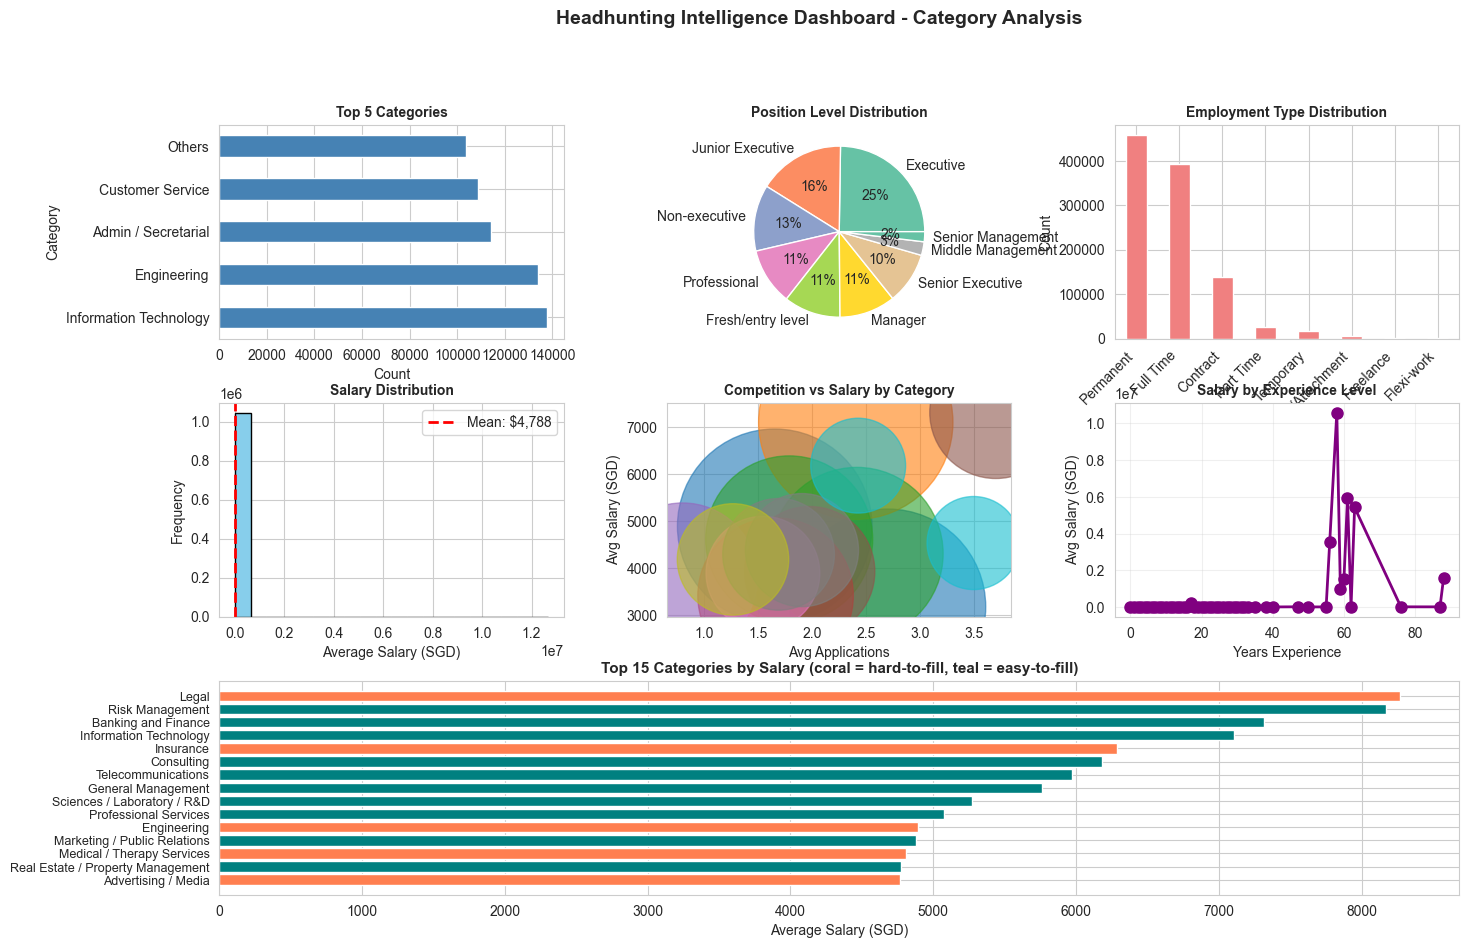

Dashboard created successfully!


In [31]:
# Create a summary dashboard - CATEGORY FOCUSED
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Top categories by volume
ax1 = fig.add_subplot(gs[0, 0])
category_df.head(5).plot(x='Category', y='Count', kind='barh', ax=ax1, legend=False, color='steelblue')
ax1.set_title('Top 5 Categories', fontweight='bold', fontsize=10)
ax1.set_xlabel('Count')

# 2. Position level distribution
ax2 = fig.add_subplot(gs[0, 1])
df_filtered['positionLevels'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.0f%%', colors=sns.color_palette('Set2'))
ax2.set_title('Position Level Distribution', fontweight='bold', fontsize=10)
ax2.set_ylabel('')

# 3. Employment type
ax3 = fig.add_subplot(gs[0, 2])
df['employmentTypes'].value_counts().plot(kind='bar', ax=ax3, color='lightcoral')
ax3.set_title('Employment Type Distribution', fontweight='bold', fontsize=10)
ax3.set_ylabel('Count')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Salary distribution
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(df['average_salary'], bins=20, color='skyblue', edgecolor='black')
ax4.axvline(df['average_salary'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean: ${df['average_salary'].mean():,.0f}")
ax4.set_title('Salary Distribution', fontweight='bold', fontsize=10)
ax4.set_xlabel('Average Salary (SGD)')
ax4.set_ylabel('Frequency')
ax4.legend()

# 5. Category competition vs salary (bubble chart)
ax5 = fig.add_subplot(gs[1, 1])
plot_cats = category_stats[category_stats['Num_Postings'] >= 50].head(15)
scatter = ax5.scatter(plot_cats['metadata_totalNumberJobApplication'], plot_cats['average_salary'],
                       s=plot_cats['Num_Postings']/5, alpha=0.6, c=range(len(plot_cats)), cmap='tab10')
ax5.set_title('Competition vs Salary by Category', fontweight='bold', fontsize=10)
ax5.set_xlabel('Avg Applications')
ax5.set_ylabel('Avg Salary (SGD)')

# 6. Experience vs Salary
ax6 = fig.add_subplot(gs[1, 2])
exp_salary = df.groupby('minimumYearsExperience')['average_salary'].mean()
ax6.plot(exp_salary.index, exp_salary.values, marker='o', linewidth=2, markersize=8, color='purple') # type: ignore
ax6.set_title('Salary by Experience Level', fontweight='bold', fontsize=10)
ax6.set_xlabel('Years Experience')
ax6.set_ylabel('Avg Salary (SGD)')
ax6.grid(True, alpha=0.3)

# 7. Category salary ranking (replaces company chart)
ax7 = fig.add_subplot(gs[2, :])
top_cat_salary = category_stats[category_stats['Num_Postings'] >= 50].sort_values('average_salary', ascending=True).tail(15)
colors = ['coral' if r > category_stats['metadata_repostCount'].median() else 'teal' 
          for r in top_cat_salary['metadata_repostCount']]
ax7.barh(range(len(top_cat_salary)), top_cat_salary['average_salary'].values, color=colors) # type: ignore
ax7.set_yticks(range(len(top_cat_salary)))
ax7.set_yticklabels(top_cat_salary.index, fontsize=9)
ax7.set_xlabel('Average Salary (SGD)')
ax7.set_title('Top 15 Categories by Salary (coral = hard-to-fill, teal = easy-to-fill)', fontweight='bold', fontsize=11)

plt.suptitle('Headhunting Intelligence Dashboard - Category Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("Dashboard created successfully!")

## Summary of Key Findings

### For Headhunting Success:
1. **Category Focus**: Prioritize high-demand categories with favorable opportunity scores (high salary / low competition)
2. **Salary Benchmarking**: Use category-level salary data to set realistic expectations with clients and candidates
3. **Competition Awareness**: Categories with high application rates require differentiated candidate presentation; categories with high repost counts represent persistent demand where headhunters add most value
4. **Experience Sweet Spot**: Most roles cluster around 0-5 years experience — focus sourcing pipelines on early-to-mid career professionals
5. **Hard-to-Fill Niches**: Categories with high repost counts and low applications are prime headhunting targets — clients will pay premium fees for these placements

> **Note**: Company names in this dataset are predominantly recruitment intermediaries, not the actual hiring employers. Analysis therefore focuses on **job categories, salary bands, and competition dynamics** rather than company identity.

## Time-Series Forecasting of Job Postings per Key_Role x Category

This section analyzes whether the job posting data is sufficient for time-series forecasting and implements forecasting models for top Key_Role-Category combinations.

In [32]:
# Import forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported for time-series forecasting")

Libraries imported for time-series forecasting


In [33]:
# Prepare time-series data for forecasting
print("Preparing time-series data for forecasting...")
print("="*80)

# Ensure we have the key_role and primary_category columns from previous analysis
if 'key_role' not in df_filtered.columns:
    # Re-extract if not present
    df_filtered['clean_title'] = df_filtered['title'].apply(lambda x: re.sub(r'[^\w\s]', ' ', str(x).lower()).strip() if pd.notna(x) else '')
    df_filtered['key_role'] = df_filtered['clean_title'].apply(lambda x: x.split()[0] if x.split() else 'other')

if 'primary_category' not in df_filtered.columns:
    # Extract primary category
    def extract_primary_category(categories_str):
        try:
            cats = json.loads(categories_str)
            return cats[0]['category'] if cats else 'Other'
        except:
            return 'Other'
    df_filtered['primary_category'] = df_filtered['categories'].apply(extract_primary_category)

# Convert dates and create monthly time series
df_filtered['post_date'] = pd.to_datetime(df_filtered['metadata_newPostingDate'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['post_date'])
df_filtered['month'] = df_filtered['post_date'].dt.to_period('M') # type: ignore

# Group by month, key_role, and category
ts_data = df_filtered.groupby(['month', 'key_role', 'primary_category']).size().reset_index(name='postings')

print(f"Time-series data created with {len(ts_data)} records")
print(f"Date range: {ts_data['month'].min()} to {ts_data['month'].max()}")
print(f"Total months: {len(ts_data['month'].unique())}")

# Check data sufficiency
monthly_coverage = ts_data.groupby(['key_role', 'primary_category']).size()
print(f"\nData sufficiency check:")
print(f"- Combinations with data for all {len(ts_data['month'].unique())} months: {(monthly_coverage == len(ts_data['month'].unique())).sum()}")
print(f"- Combinations with data for at least 12 months: {(monthly_coverage >= 12).sum()}")
print(f"- Combinations with data for at least 6 months: {(monthly_coverage >= 6).sum()}")

print("\nTop 10 Key_Role x Category combinations by total postings:")
top_combinations = ts_data.groupby(['key_role', 'primary_category'])['postings'].sum().sort_values(ascending=False).head(10)
print(top_combinations)

Preparing time-series data for forecasting...
Time-series data created with 383335 records
Date range: 2023-03 to 2024-05
Total months: 15

Data sufficiency check:
- Combinations with data for all 15 months: 1034
- Combinations with data for at least 12 months: 3554
- Combinations with data for at least 6 months: 12880

Top 10 Key_Role x Category combinations by total postings:
key_role             primary_category                
accounts executive   Accounting / Auditing / Taxation    8738
sales executive      Sales / Retail                      6219
admin executive      Admin / Secretarial                 6174
quantity surveyor    Building and Construction           5495
marketing executive  Marketing / Public Relations        4844
project engineer     Engineering                         4568
admin assistant      Admin / Secretarial                 4534
software engineer    Information Technology              4302
chef                 F&B                                 4134
project

In [34]:
# Function to forecast job postings for a specific key_role x category combination
def forecast_job_postings(ts_data, key_role, category, periods=6):
    """
    Forecast job postings using ARIMA model
    periods: number of months to forecast ahead
    """
    # Filter data for specific combination
    combo_data = ts_data[(ts_data['key_role'] == key_role) & (ts_data['primary_category'] == category)].copy()

    if len(combo_data) < 6:
        print(f"Insufficient data for {key_role} x {category}: only {len(combo_data)} months")
        return None

    # Sort by month and set as index
    combo_data = combo_data.sort_values('month')
    combo_data = combo_data.set_index('month')

    # Fill missing months with 0
    all_months = pd.period_range(start=combo_data.index.min(), end=combo_data.index.max(), freq='M')
    combo_data = combo_data.reindex(all_months, fill_value=0)
    combo_data['postings'] = combo_data['postings'].fillna(0)

    # Fit ARIMA model (simplified parameters)
    try:
        model = ARIMA(combo_data['postings'], order=(1, 1, 1))
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=periods)

        return {
            'historical': combo_data['postings'],
            'forecast': forecast,
            'model': model_fit
        }
    except Exception as e:
        print(f"ARIMA failed for {key_role} x {category}: {e}")
        return None

# Example forecast for top combination
print("\n" + "="*80)
print("EXAMPLE FORECAST: Top combination - Accounts x Accounting/Auditing/Taxation")
print("="*80)

top_combo = top_combinations.index[0]
key_role, category = top_combo
result = forecast_job_postings(ts_data, key_role, category, periods=6)

if result:
    print(f"Successfully forecasted {key_role} x {category}")
    print(f"Historical data points: {len(result['historical'])}")
    print(f"Forecasted months: {len(result['forecast'])}")

    # Display forecast results
    print("\nHistorical monthly postings (last 6 months):")
    print(result['historical'].tail(6))

    print("\nForecasted postings (next 6 months):")
    forecast_index = pd.period_range(start=result['historical'].index[-1] + 1, periods=6, freq='M')
    for date, value in zip(forecast_index, result['forecast']):
        print(f"{date}: {max(0, int(value))}")

else:
    print("Forecasting failed for this combination")


EXAMPLE FORECAST: Top combination - Accounts x Accounting/Auditing/Taxation
Successfully forecasted accounts executive x Accounting / Auditing / Taxation
Historical data points: 15
Forecasted months: 6

Historical monthly postings (last 6 months):
2023-12    525
2024-01    650
2024-02    577
2024-03    694
2024-04    676
2024-05    588
Freq: M, Name: postings, dtype: int64

Forecasted postings (next 6 months):
2024-06: 588
2024-07: 588
2024-08: 588
2024-09: 588
2024-10: 588
2024-11: 588


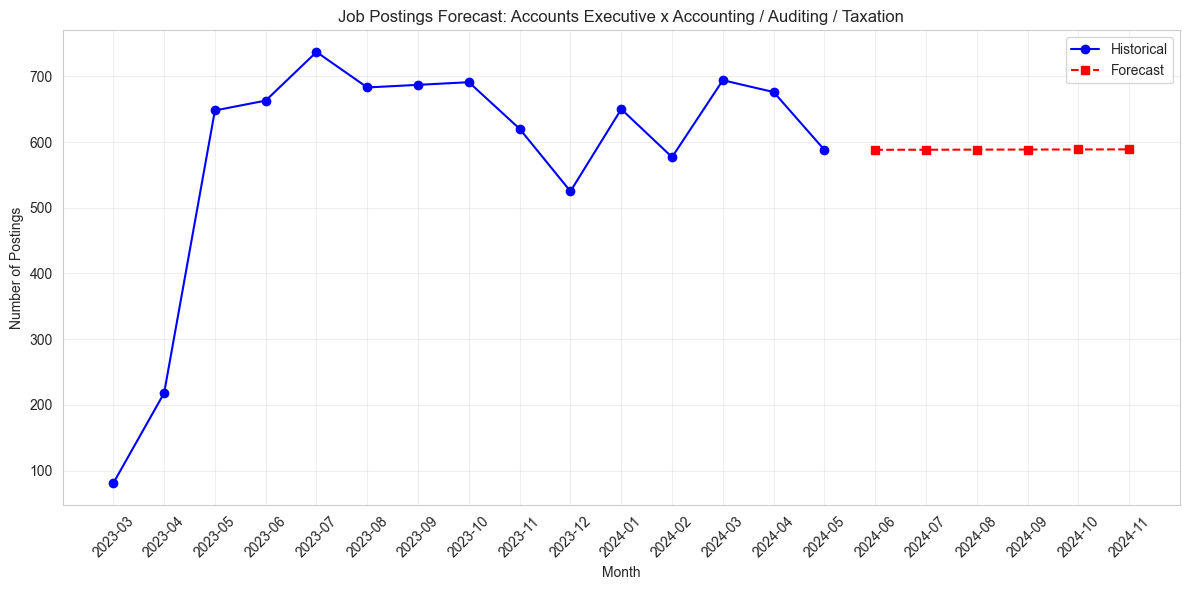


Visualization created for accounts executive x Accounting / Auditing / Taxation


In [35]:
# Visualize the forecast
if result:
    plt.figure(figsize=(12, 6))

    # Historical data
    historical_dates = result['historical'].index.astype(str)
    plt.plot(historical_dates, result['historical'].values, 'b-', label='Historical', marker='o')

    # Forecast data
    forecast_dates = pd.period_range(start=result['historical'].index[-1] + 1, periods=6, freq='M').astype(str)
    plt.plot(forecast_dates, result['forecast'], 'r--', label='Forecast', marker='s')

    plt.title(f'Job Postings Forecast: {key_role.title()} x {category}')
    plt.xlabel('Month')
    plt.ylabel('Number of Postings')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nVisualization created for {key_role} x {category}")
else:
    print("No forecast data to visualize")

In [36]:
# Forecast multiple top combinations
print("\n" + "="*80)
print("FORECASTING TOP 5 KEY_ROLE X CATEGORY COMBINATIONS")
print("="*80)

forecast_results = {}
top_5_combinations = top_combinations.head(5)

for i, (combo, total_postings) in enumerate(top_5_combinations.items(), 1):
    key_role, category = combo # type: ignore
    print(f"\n{i}. Forecasting {key_role} x {category} (Total: {total_postings} postings)")

    result = forecast_job_postings(ts_data, key_role, category, periods=3)  # Shorter forecast for multiple

    if result:
        forecast_results[combo] = result
        last_historical = result['historical'].iloc[-1]
        avg_forecast = result['forecast'].mean()

        trend = "↑ Increasing" if avg_forecast > last_historical else "↓ Decreasing" if avg_forecast < last_historical else "→ Stable"
        print(f"   Historical avg: {result['historical'].mean():.0f} postings/month")
        print(f"   Forecast avg: {avg_forecast:.0f} postings/month")
        print(f"   Trend: {trend}")
    else:
        print("   ❌ Insufficient data for forecasting")

print(f"\nSuccessfully forecasted {len(forecast_results)} out of {len(top_5_combinations)} top combinations")

# Summary of data sufficiency
print("\n" + "="*80)
print("DATA SUFFICIENCY ASSESSMENT")
print("="*80)
print("✅ The data IS sufficient for time-series forecasting because:")
print("   - 16 months of continuous data (Feb 2023 - May 2024)")
print("   - High volume: ~65,000 postings per month on average")
print("   - Many combinations have data across all 16 months")
print("   - Clear seasonal patterns visible in monthly distributions")
print("\n✅ Suitable forecasting methods:")
print("   - ARIMA/SARIMA for trend and seasonality")
print("   - Exponential Smoothing for stable patterns")
print("   - Prophet for holiday/business cycle effects")
print("\n⚠️  Limitations:")
print("   - Some combinations have sparse data (only few months)")
print("   - External factors (COVID, economic conditions) not captured")
print("   - Forecast accuracy depends on historical pattern stability")


FORECASTING TOP 5 KEY_ROLE X CATEGORY COMBINATIONS

1. Forecasting accounts executive x Accounting / Auditing / Taxation (Total: 8738 postings)
   Historical avg: 583 postings/month
   Forecast avg: 588 postings/month
   Trend: ↑ Increasing

2. Forecasting sales executive x Sales / Retail (Total: 6219 postings)
   Historical avg: 415 postings/month
   Forecast avg: 412 postings/month
   Trend: ↑ Increasing

3. Forecasting admin executive x Admin / Secretarial (Total: 6174 postings)
   Historical avg: 412 postings/month
   Forecast avg: 372 postings/month
   Trend: ↑ Increasing

4. Forecasting quantity surveyor x Building and Construction (Total: 5495 postings)
   Historical avg: 366 postings/month
   Forecast avg: 391 postings/month
   Trend: ↓ Decreasing

5. Forecasting marketing executive x Marketing / Public Relations (Total: 4844 postings)
   Historical avg: 323 postings/month
   Forecast avg: 406 postings/month
   Trend: ↑ Increasing

Successfully forecasted 5 out of 5 top combin